# JFK Fligths - Delay Prediction

Diego Rodríguez García - 21/09/2023


## 0. Description

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. 

You have been recently hired as a Data Scientist by the DOT to help them mitigate the consequences of delayed flights. Our assignment is the development of a machine learning model that allows to predict the probability of a flight been delayed. 

As a first exercise, we are implementing a **model to predict whether a flight will have a delay higher than 15 minutes.** The data available contains all relevant information for flights arriving to JFK airport (NYC). This is the data that we will use to build a first pilot version of the model. If this model is proven effective, our model will be extended to incorporate all airports at a national level.  

## 1. Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, model_selection, metrics, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import __version__ as sklearn_version
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
print('The scikit-learn version is {}.'.format(sklearn_version))

The scikit-learn version is 1.5.0.


## 2. Importing data

Before starting with our ML Checklist, the first stage is to import the data for this project (JFKFlights). This dataset is available in the official website for the US Bureau of Transportation Statistics, but we'll directly download it from a public repository in GitHub. The dataset is split in two files because of size limitations from Github. We'll have to import them independently and merge them. 

In [3]:
url1 = 'https://bit.ly/3jAxEwk'
url2 = 'https://bit.ly/3t8qJOf'

In [4]:
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)

In [5]:
df=pd.concat([df1,df2],axis=0)

## 3. Data understanding and analysis

### `3.1. First impressions`

In [6]:
df.head()

Unnamed: 0     FL_DATE  OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN  \
0           0  2018-02-01                20363.0   N299PQ    BNA   
1           1  2018-02-01                20363.0   N920XJ    RDU   
2           2  2018-02-01                20363.0   N605LR    BUF   
3           3  2018-02-01                20363.0   N800AY    ORF   
4           4  2018-02-01                20363.0   N600LR    BOS   

     ORIGIN_CITY_NAME ORIGIN_STATE_NM DEST DEST_CITY_NAME DEST_STATE_NM  \
0       Nashville, TN       Tennessee  JFK   New York, NY      New York   
1  Raleigh/Durham, NC  North Carolina  JFK   New York, NY      New York   
2         Buffalo, NY        New York  JFK   New York, NY      New York   
3         Norfolk, VA        Virginia  JFK   New York, NY      New York   
4          Boston, MA   Massachusetts  JFK   New York, NY      New York   

   CRS_DEP_TIME  TAXI_OUT  CRS_ARR_TIME  ARR_DEL15  CRS_ELAPSED_TIME  DISTANCE  
0          1359      27.0          1719        0.0             140.0     765.0  
1          1354      37.0          1541        0.0             107.0     427.0  
2          1529      21.0          1709        0.0             100.0     301.0  
3          1704      36.0          1845        0.0             101.0     290.0  
4          1325      20.0          1454        0.0              89.0     187.0

In [7]:
df.shape

(250152, 16)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250152 entries, 0 to 150151
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             250152 non-null  int64  
 1   FL_DATE                250152 non-null  object 
 2   OP_CARRIER_AIRLINE_ID  237644 non-null  float64
 3   TAIL_NUM               235143 non-null  object 
 4   ORIGIN                 250152 non-null  object 
 5   ORIGIN_CITY_NAME       250152 non-null  object 
 6   ORIGIN_STATE_NM        250152 non-null  object 
 7   DEST                   250152 non-null  object 
 8   DEST_CITY_NAME         250152 non-null  object 
 9   DEST_STATE_NM          250152 non-null  object 
 10  CRS_DEP_TIME           250152 non-null  int64  
 11  TAXI_OUT               232641 non-null  float64
 12  CRS_ARR_TIME           250152 non-null  int64  
 13  ARR_DEL15              250152 non-null  float64
 14  CRS_ELAPSED_TIME       250152 non-null  f

In [9]:
df.describe().T

count           mean           std      min  \
Unnamed: 0             250152.0  125075.500000  72212.806607      0.0   
OP_CARRIER_AIRLINE_ID  237644.0   20152.000736    297.881929  19690.0   
CRS_DEP_TIME           250152.0    1334.611164    529.100385      3.0   
TAXI_OUT               232641.0      18.189820      9.609596      1.0   
CRS_ARR_TIME           250152.0    1419.131404    580.986009      1.0   
ARR_DEL15              250152.0       0.210400      0.407594      0.0   
CRS_ELAPSED_TIME       250152.0     195.647706     97.374339     47.0   
DISTANCE               250152.0    1258.844866    898.116163     94.0   

                            25%       50%        75%       max  
Unnamed: 0             62537.75  125075.5  187613.25  250151.0  
OP_CARRIER_AIRLINE_ID  19790.00   20363.0   20409.00   21171.0  
CRS_DEP_TIME             915.00    1258.0    1744.00    2359.0  
TAXI_OUT                  12.00      16.0      21.00     166.0  
CRS_ARR_TIME             944.00    1455.0    1914.00    2400.0  
ARR_DEL15                  0.00       0.0       0.00       1.0  
CRS_ELAPSED_TIME         109.00     167.0     306.00     595.0  
DISTANCE                 427.00    1028.0    2248.00    4983.0

Here is the available information explaining each variable in the dataset:

* **FL_DATE**: Date of the observation
* **OP_CARRIER_AIRLINE_ID**: IAn identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
* **TAIL_NUM**: Tail Number, unique identifier for the plane
* **ORIGIN**: origin airport
* **ORIGIN_CITY_NAME**: origin airport
* **ORIGIN_STATE_NM**: origin state (USA)
* **DEST**: destination airport (JFK for all registers)
* **DEST_CITY_NAME**: destination city (NYC for all registers)
* **DEST_STATE_NM**: destination state (NY for all registers)
* **CRS_DEP_TIME**: scheduled departure time
* **TAXI_OUT**: run away time (time between exit from terminal and take-off) 
* **CRS_ARR_TIME**: scheduled arrival time
* **ARR_DEL15**: boolean (1/0) indicating if there has been more than 15 minutes delay
* **CRS_ELAPSED_TIME**: expected flight duration
* **DISTANCE**: distance between airports

We are working on a classification problem, and our target will be the variable **ARR_DEL15**.

In [10]:
df.columns=df.columns.str.lower()
df.columns

Index(['unnamed: 0', 'fl_date', 'op_carrier_airline_id', 'tail_num', 'origin',
       'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_nm', 'crs_dep_time', 'taxi_out', 'crs_arr_time',
       'arr_del15', 'crs_elapsed_time', 'distance'],
      dtype='object')

In [11]:
target="arr_del15"

### `3.2. Feature variety`

We have observed there are both numerical and categorical features.

In [12]:
df.select_dtypes(include=['object']).describe().T

count unique              top    freq
fl_date           250152    730       2018-07-19     394
tail_num          235143   2645           N110AN     761
origin            250152     72              LAX   25345
origin_city_name  250152     70  Los Angeles, CA   25345
origin_state_nm   250152     32       California   51137
dest              250152      1              JFK  250152
dest_city_name    250152      1     New York, NY  250152
dest_state_nm     250152      1         New York  250152

Knowing there is always the same destiny (JFK Airport, New York) we are going to remove the columns related to it.

In [13]:
df.drop(columns=["dest","dest_city_name","dest_state_nm"],inplace=True)
df.select_dtypes(include=['object']).describe().T

count unique              top   freq
fl_date           250152    730       2018-07-19    394
tail_num          235143   2645           N110AN    761
origin            250152     72              LAX  25345
origin_city_name  250152     70  Los Angeles, CA  25345
origin_state_nm   250152     32       California  51137

In [14]:
df.describe().T

count           mean           std      min  \
unnamed: 0             250152.0  125075.500000  72212.806607      0.0   
op_carrier_airline_id  237644.0   20152.000736    297.881929  19690.0   
crs_dep_time           250152.0    1334.611164    529.100385      3.0   
taxi_out               232641.0      18.189820      9.609596      1.0   
crs_arr_time           250152.0    1419.131404    580.986009      1.0   
arr_del15              250152.0       0.210400      0.407594      0.0   
crs_elapsed_time       250152.0     195.647706     97.374339     47.0   
distance               250152.0    1258.844866    898.116163     94.0   

                            25%       50%        75%       max  
unnamed: 0             62537.75  125075.5  187613.25  250151.0  
op_carrier_airline_id  19790.00   20363.0   20409.00   21171.0  
crs_dep_time             915.00    1258.0    1744.00    2359.0  
taxi_out                  12.00      16.0      21.00     166.0  
crs_arr_time             944.00    1455.0    1914.00    2400.0  
arr_del15                  0.00       0.0       0.00       1.0  
crs_elapsed_time         109.00     167.0     306.00     595.0  
distance                 427.00    1028.0    2248.00    4983.0

Let's see how balanced the problem is

<Axes: xlabel='arr_del15'>

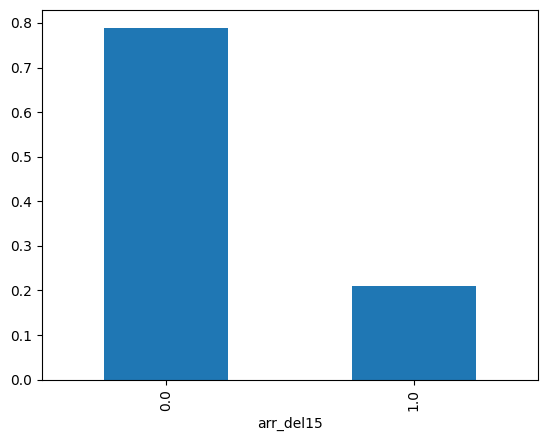

In [15]:
df[target].value_counts(normalize=True).plot(kind="bar")

Even though the delayed flighs are the 20% aproximately, we can consider the problem as a balanced one.

### `3.3. Nulls`

In [16]:
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id    12508
tail_num                 15009
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.1. op_carrier_airline_id

* **OP_CARRIER_AIRLINE_ID**: IAn identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.

In [17]:
df.op_carrier_airline_id.value_counts(dropna=False)

op_carrier_airline_id
20409.0    78587
19790.0    58894
20363.0    40833
19805.0    30694
NaN        12508
20398.0     8814
19930.0     8591
20452.0     5044
20304.0     3993
21171.0      944
19690.0      695
20397.0      555
Name: count, dtype: int64

We can not manage to study the feature much deeper because it is an id. A solution may be changing the nulls into whatever in order to do later the encoding.

In [18]:
df.op_carrier_airline_id.fillna("NaN",inplace=True)
df.isna().sum()

C:\Users\diego\AppData\Local\Temp\ipykernel_21868\1103958682.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.op_carrier_airline_id.fillna("NaN",inplace=True)
C:\Users\diego\AppData\Local\Temp\ipykernel_21868\1103958682.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.op_carrier_airline_id.fillna("NaN",inplace=True)


unnamed: 0                   0
fl_date                      0
op_carrier_airline_id        0
tail_num                 15009
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.2. tail_num

* **TAIL_NUM**: Tail Number, unique identifier for the plane

In [19]:
df.tail_num.value_counts(dropna=False)

tail_num
NaN       15009
N110AN      761
N113AN      751
N111ZM      748
N115NN      740
          ...  
N197UW        1
N986AN        1
N315RJ        1
N801AW        1
N945DN        1
Name: count, Length: 2646, dtype: int64

Same as before

In [20]:
df.tail_num.fillna("NaN",inplace=True)
df.isna().sum()

C:\Users\diego\AppData\Local\Temp\ipykernel_21868\1173787865.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.tail_num.fillna("NaN",inplace=True)


unnamed: 0                   0
fl_date                      0
op_carrier_airline_id        0
tail_num                     0
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.3. taxi_out

* **TAXI_OUT**: run away time (time between exit from terminal and take-off) 

In [21]:
df.taxi_out.value_counts(dropna=False)

taxi_out
13.0     18840
12.0     18344
14.0     18119
NaN      17511
15.0     16614
         ...  
146.0        1
161.0        1
159.0        1
140.0        1
156.0        1
Name: count, Length: 155, dtype: int64

Let's replace them with the value -1.

In [22]:
df.taxi_out.fillna(-1,inplace=True)
df.isna().sum()

C:\Users\diego\AppData\Local\Temp\ipykernel_21868\3769774478.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.taxi_out.fillna(-1,inplace=True)


unnamed: 0               0
fl_date                  0
op_carrier_airline_id    0
tail_num                 0
origin                   0
origin_city_name         0
origin_state_nm          0
crs_dep_time             0
taxi_out                 0
crs_arr_time             0
arr_del15                0
crs_elapsed_time         0
distance                 0
dtype: int64

### `3.4. More data cleaning`

In [23]:
df['unnamed: 0'].value_counts(dropna=False)

unnamed: 0
0         1
166758    1
166760    1
166761    1
166762    1
         ..
83388     1
83389     1
83390     1
83391     1
250151    1
Name: count, Length: 250152, dtype: int64

We can consider this feature as an id, so we can remove it aswell

In [24]:
df.drop(columns=["unnamed: 0"],inplace=True)

In [25]:
df['origin_city_name'].value_counts(dropna=False)

origin_city_name
Los Angeles, CA      25345
San Francisco, CA    15228
Boston, MA           11201
Orlando, FL           9450
Washington, DC        8197
                     ...  
Daytona Beach, FL      365
Hyannis, MA            171
Eagle, CO              161
Santa Ana, CA           68
Jackson, WY             29
Name: count, Length: 70, dtype: int64

In [26]:
df['origin'].value_counts(dropna=False)

origin
LAX    25345
SFO    15228
BOS    11201
MCO     9450
CLT     7769
       ...  
IAH      192
HYA      171
EGE      161
SNA       68
JAC       29
Name: count, Length: 72, dtype: int64

Both features seem to be quite similar. Thus, as they are not equal, we are maintaining both in our dataset.

 ### `3.5. Range of target values`

#### 3.5.1. Across some features

The evaluation of the target distribution is a fundamental step in supervised learning problems. What's the fraction of 1s in my dataset? For categorical variables, how's the target distributed across features?

In [27]:
def plot_hist_and_boxplot_by_target(df, input_name, target_name, hist_stat = 'count'):
    df_plot = df.copy().dropna()
    fig = plt.figure(figsize=(10, 3))
    fig.suptitle(input_name, fontsize=16)
    ax1 = fig.add_subplot(121)
    sns.histplot(data=df_plot.query(f"{target_name} == 1"), x=input_name, bins = 25, alpha=.5, stat = hist_stat, ax = ax1)
    sns.histplot(data=df_plot.query(f"{target_name} == 0"), x=input_name, bins = 25, alpha=.5, stat = hist_stat, ax = ax1)
    ax2 = fig.add_subplot(122)
    sns.boxplot(data=df_plot, x=target_name, y=input_name, ax=ax2)
    ax2.set_xlabel('Delayed (1) or Not (0)')

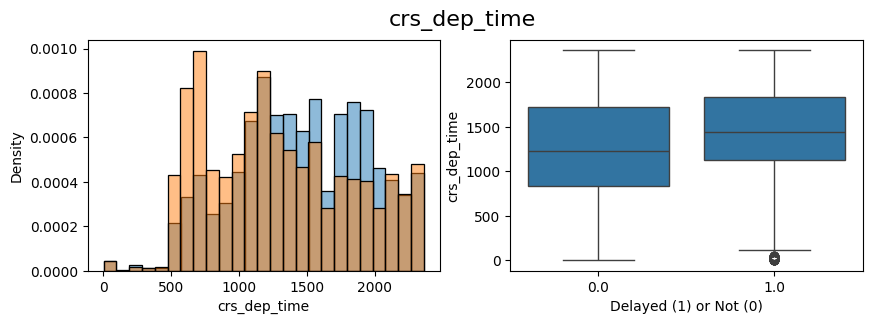

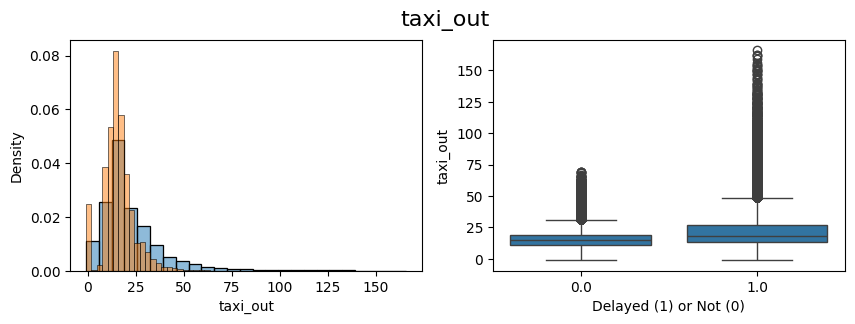

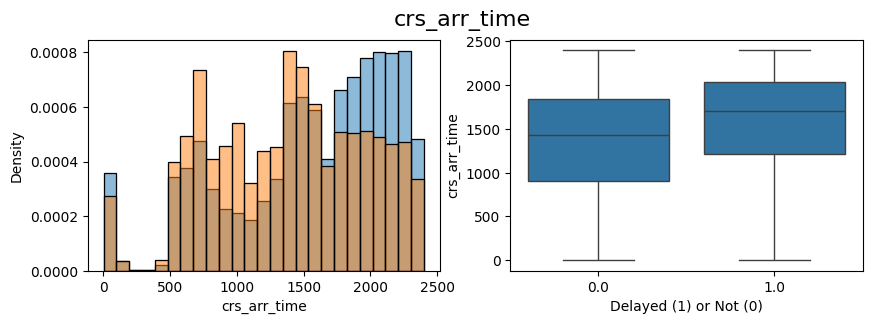

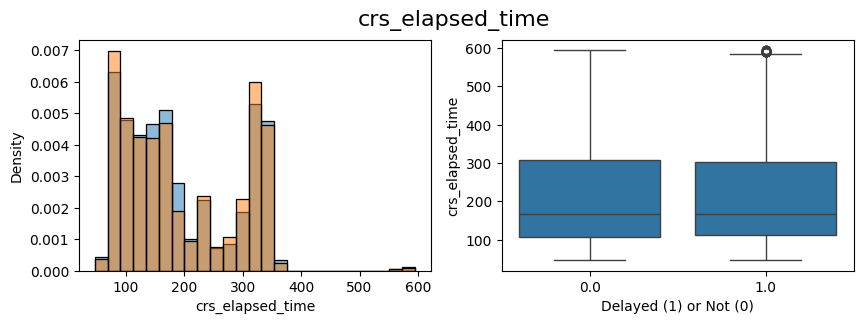

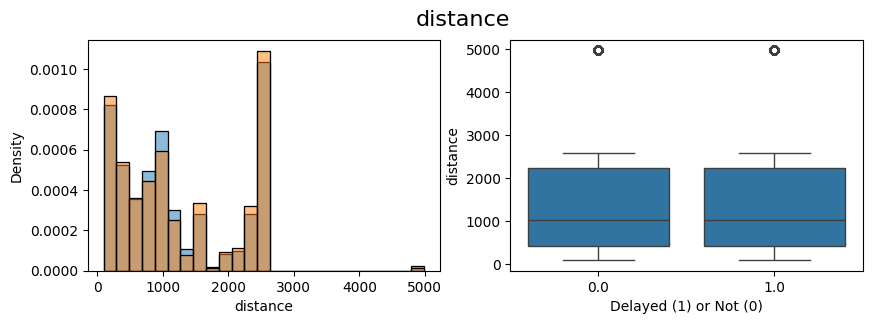

In [28]:
num_cols = list(df.select_dtypes(include = ['float', 'int']).columns)
num_cols = [c for c in num_cols if c != target]

for num_col in num_cols:
    plot_hist_and_boxplot_by_target(df,num_col,target,'density')

The features crs_elapsed_time and distance seem to have a good target distribution. However, in crs_dep_time, taxi_out and crs_arr_time we can see more differences. We considered our model will take this into account.

In [29]:
def plot_barplot_by_target(df, variable, target, normalized = True, stacked = True):
    df_plot = df.groupby([target, variable]).size().reset_index()
    df_plot = df_plot.pivot(index=variable, columns=target)
    df_plot.columns = ["non_delayed", "delayed"]
    df_total = df_plot.sum(axis=1).reset_index(name="conteo_total")
    df_plot = df_plot.merge(df_total, on = variable)
    if normalized:
        df_plot["non_delayed"] /= df_plot["conteo_total"]
        df_plot["delayed"] /= df_plot["conteo_total"]
    df_plot.index = df_plot[variable]
    df_plot.drop(columns = [variable, "conteo_total"], inplace = True)
    df_plot.plot(kind="bar", stacked=stacked, figsize=(10, 3))
    return df_plot.sort_values("delayed", ascending = False,)

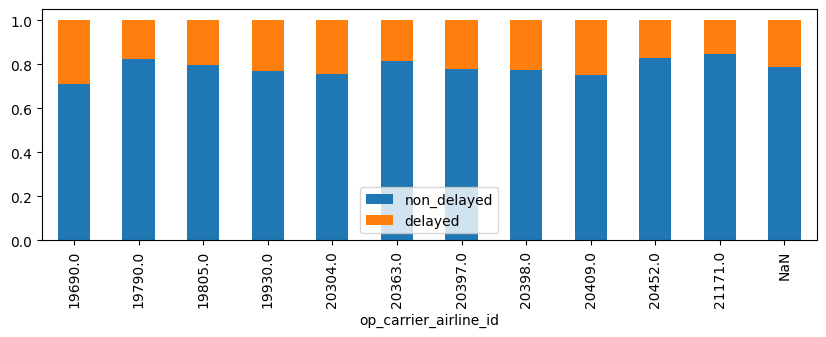

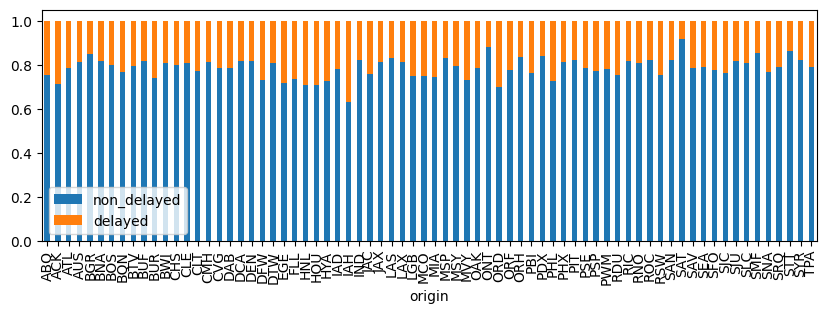

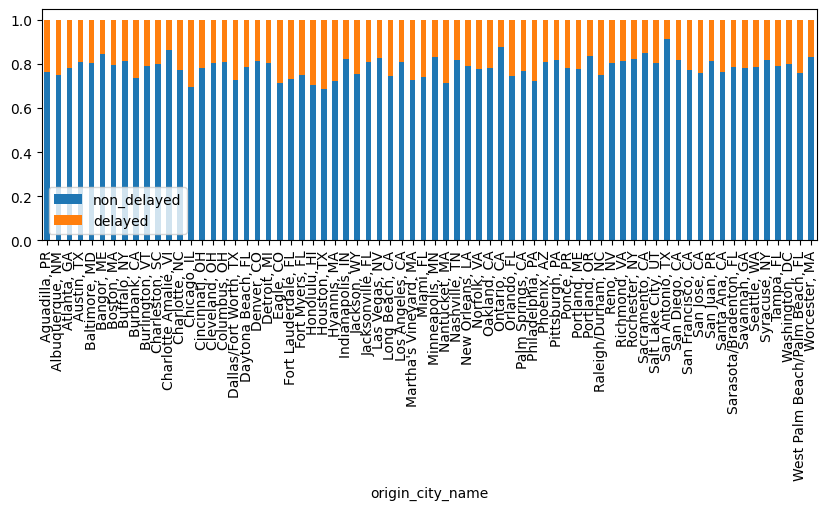

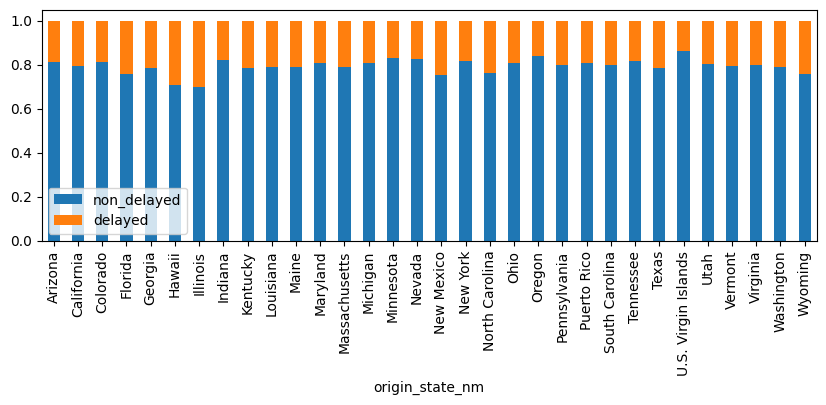

In [30]:
cat_cols = list(df.select_dtypes(exclude = ['float', 'int']).columns)
cat_cols = [c for c in cat_cols if c not in ["fl_date", "tail_num"]]

for cat_col in cat_cols:
    plot_barplot_by_target(df,cat_col,target,True)

There are some cities such as Illinois and Hawaii which delaying percentage is quite lower.

#### 3.5.2. Temporarily

In [31]:
df_daily = df[['fl_date','arr_del15']].groupby(['fl_date']).mean()
df_daily.head()

arr_del15
fl_date              
2018-01-01   0.315789
2018-01-02   0.320588
2018-01-03   0.211806
2018-01-04   0.833333
2018-01-05   0.877273

Our index is not a date variable. We need to transform it to date format in order for pandas tu interpret it as such (very useful for summaries and plots)

In [32]:
df_daily.index=pd.to_datetime(df_daily.index,format='%Y-%m-%d')
df['fl_date']=pd.to_datetime(df['fl_date'],format='%Y-%m-%d')

We are finally ready to plot distribution of delayed flights across time! 

<Axes: xlabel='fl_date'>

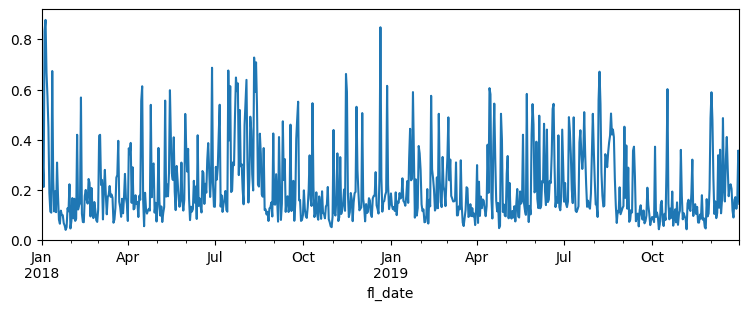

In [33]:
plt.figure(figsize=[9,3])
df_daily['arr_del15'].plot()

The daily plot might not be as clean as we expected. Let's try to plot the weekly mean for the same variable. A weekely mean might allow us to appreciate a certain seasonality of the series. 

In [34]:
df_weekly_mean = df_daily['arr_del15'].resample('W').mean()

<Axes: xlabel='fl_date'>

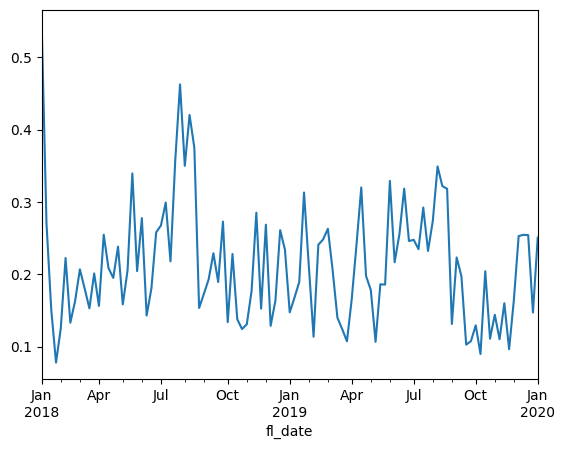

In [35]:
df_weekly_mean.plot()

And let's do the same for a monthly frequency

In [36]:
df_monthly_mean = df_daily['arr_del15'].resample('M').mean()

C:\Users\diego\AppData\Local\Temp\ipykernel_21868\3022096551.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_mean = df_daily['arr_del15'].resample('M').mean()


<Axes: xlabel='fl_date'>

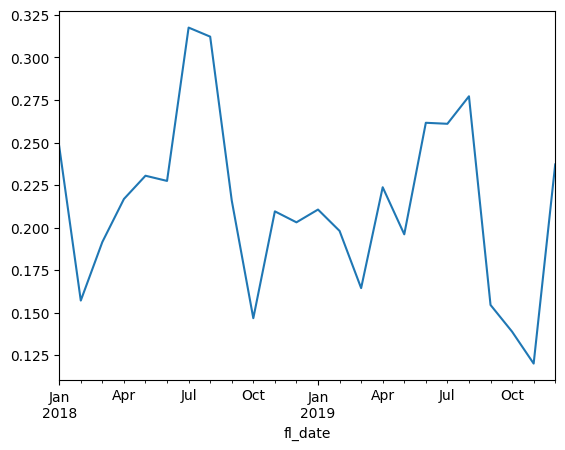

In [37]:
df_monthly_mean.plot()

It seems that the majority of the delays are concentrated during the summer.

Let's see it over the day time.

<Axes: ylabel='Frequency'>

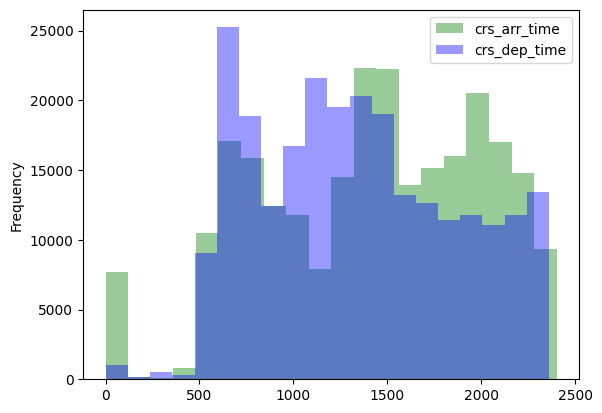

In [38]:
df['crs_arr_time'].plot(kind='hist',bins=20,color='green',alpha=0.4,legend=True)
df['crs_dep_time'].plot(kind='hist',bins=20,color='blue',alpha=0.4,legend=True)

<Axes: ylabel='Frequency'>

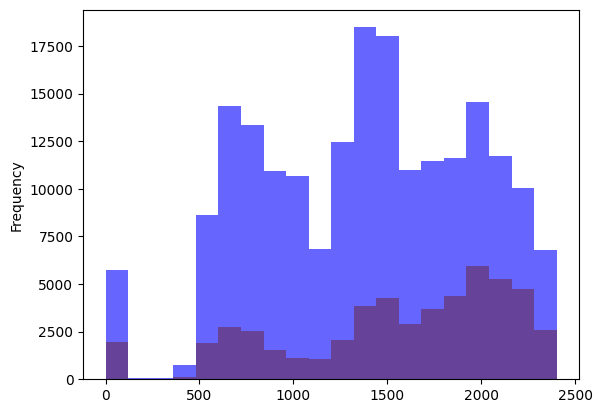

In [39]:
df[df.arr_del15==1]['crs_arr_time'].plot(kind='hist',bins=20,color='orange',alpha=1)
df[df.arr_del15==0]['crs_arr_time'].plot(kind='hist',bins=20,color='blue',alpha=0.6)

There seems to be a higher number of delayed flights at the end of the day, absolutely and relatively.

<Axes: ylabel='Frequency'>

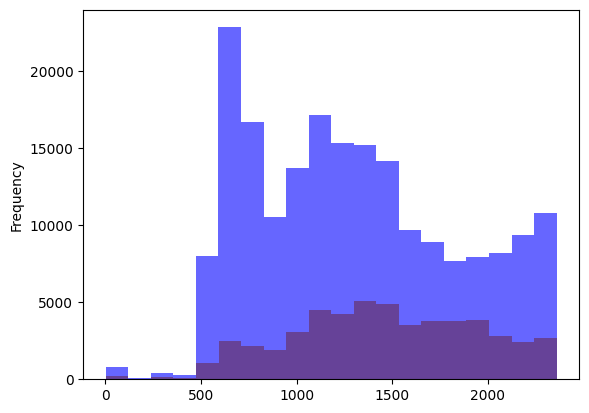

In [40]:
df[df.arr_del15==1]['crs_dep_time'].plot(kind='hist',bins=20,color='orange',alpha=1)
df[df.arr_del15==0]['crs_dep_time'].plot(kind='hist',bins=20,color='blue',alpha=0.6)

Same here.

Now let's save our df in case we need to check it again after next steps.

In [41]:
df_before_data_prep = df.copy()

## 4. Data preparation

### `4.1. Data transformation`

We need to transform the categorical features into numerical. One-hot encodings make sense for variables with a reasonable number of different values.

However, if a categorical variable has too many possible values, we might need to think about transforming its distribution first.

In [99]:
df.select_dtypes(include=['object']).describe().T

count unique              top     freq
op_carrier_airline_id  250152.0   12.0          20409.0  78587.0
tail_num                 250152   2646              NaN    15009
origin                   250152     72              LAX    25345
origin_city_name         250152     70  Los Angeles, CA    25345
origin_state_nm          250152     32       California    51137

Variables ``op_carrier_airline_id``, ``origin``, ``origin_city_name``, `origin_state_nm` are ideal candidates for one-hot-encoding. They'll result in a total of 184 variables, totally fine for the decision tree and for a regular desktop computer. 

In [100]:
aux=pd.get_dummies(df[['op_carrier_airline_id','origin','origin_city_name','origin_state_nm']])
df=pd.concat([df,aux],axis=1)
df.drop(columns=['op_carrier_airline_id','origin','origin_city_name','origin_state_nm'],inplace=True)
df.shape

(250152, 194)

However, the variable TAIL_NUM has 2647 different values. We'll need to carry out a more thorough analysis for this variable.

In [101]:
df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)

C:\Users\diego\AppData\Local\Temp\ipykernel_1460\3894922256.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)
C:\Users\diego\AppData\Local\Temp\ipykernel_1460\3894922256.py:1: FutureWarning: The provided callable <function mean at 0x000001E43B542020> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)


len       sum      mean
         arr_del15 arr_del15 arr_del15
tail_num                              
NaN          15009    3109.0  0.207142
N110AN         761     164.0  0.215506
N113AN         751     134.0  0.178429
N111ZM         748     162.0  0.216578
N109NN         740     118.0  0.159459
...            ...       ...       ...
N745VJ           1       0.0  0.000000
N744P            1       0.0  0.000000
N734AR           1       0.0  0.000000
N733AR           1       0.0  0.000000
N719AN           1       0.0  0.000000

[2646 rows x 3 columns]

Let's try with frequency encoding.

In [ ]:
df_tail_num = pd.DataFrame(df['tail_num'].value_counts(dropna = False))
df_tail_num.columns = ['tail_num_count']

In [103]:
df = df.merge(df_tail_num,on='tail_num')    

In [104]:
df.drop('tail_num',axis=1,inplace=True)

### `4.2. Feature engineering`

There are plenty of new features that we could create for this use case. The feature engineering stage often plays a very important role in helping the model to achieve a better performance. 

We are transforming our FL_DATE variable into a date, and we'll include a few additional time-based variables to our dataframe (might be very helpful for the model): season, year, month, week, weekday.  

In [105]:
df['fl_date'].dtypes

dtype('<M8[ns]')

In [107]:
df['fl_date'] = pd.to_datetime(df['fl_date'])
df['season'] = df['fl_date'].dt.quarter
df['year'] = df['fl_date'].dt.year
df['month'] = df['fl_date'].dt.month
df['weekday'] = df['fl_date'].dt.weekday

In [108]:
df.head()

fl_date  crs_dep_time  taxi_out  crs_arr_time  arr_del15  \
0 2018-02-01          1359      27.0          1719        0.0   
1 2018-02-01          1354      37.0          1541        0.0   
2 2018-02-01          1529      21.0          1709        0.0   
3 2018-02-01          1704      36.0          1845        0.0   
4 2018-02-01          1325      20.0          1454        0.0   

   crs_elapsed_time  distance  op_carrier_airline_id_19690.0  \
0             140.0     765.0                          False   
1             107.0     427.0                          False   
2             100.0     301.0                          False   
3             101.0     290.0                          False   
4              89.0     187.0                          False   

   op_carrier_airline_id_19790.0  op_carrier_airline_id_19805.0  ...  \
0                          False                          False  ...   
1                          False                          False  ...   
2                          False                          False  ...   
3                          False                          False  ...   
4                          False                          False  ...   

   origin_state_nm_Utah  origin_state_nm_Vermont  origin_state_nm_Virginia  \
0                 False                    False                     False   
1                 False                    False                     False   
2                 False                    False                     False   
3                 False                    False                      True   
4                 False                    False                     False   

   origin_state_nm_Washington  origin_state_nm_Wyoming  tail_num_count  \
0                       False                    False             340   
1                       False                    False             337   
2                       False                    False             310   
3                       False                    False             265   
4                       False                    False             339   

   season  year  month  weekday  
0       1  2018      2        3  
1       1  2018      2        3  
2       1  2018      2        3  
3       1  2018      2        3  
4       1  2018      2        3  

[5 rows x 198 columns]

Let's create a weekend boolean.

In [109]:
df['weekend']=(df['weekday']>=5).astype(int)

In [110]:
df.drop(columns=['fl_date'],inplace=True)

## 5. Modelling

### `5.1. Dataset split`

This dataset is partitioned by dates. In this type of problems, the best choice is to keep the most recent records as validation set. If the behavior of the target can vary across time, do not forget that our test set needs to resemble as close as possible the scenario that we'd like our model to perform on (i.e. the most recent, the better).

In [52]:
df.pivot_table(index=['year','month'], values='arr_del15', aggfunc=[len, sum, np.mean])

len       sum      mean
           arr_del15 arr_del15 arr_del15
year month                              
2018 1          9244    1968.0  0.212895
     2          9115    1418.0  0.155568
     3          9927    1825.0  0.183842
     4         10393    2184.0  0.210141
     5         10915    2478.0  0.227027
     6         11052    2504.0  0.226565
     7         11201    3463.0  0.309169
     8         11202    3345.0  0.298607
     9         10591    2304.0  0.217543
     10        10952    1628.0  0.148649
     11        10194    2138.0  0.209731
     12        10697    2199.0  0.205572
2019 1         10245    2154.0  0.210249
     2          9381    1817.0  0.193689
     3         11084    1812.0  0.163479
     4         10308    2236.0  0.216919
     5         10797    2122.0  0.196536
     6         10543    2743.0  0.260173
     7         10661    2735.0  0.256543
     8         10782    2912.0  0.270080
     9         10120    1544.0  0.152569
     10        10426    1418.0  0.136006
     11         9937    1205.0  0.121264
     12        10385    2480.0  0.238806

We will use the last 6 months from 2019 as test set, and we will train our model with the partitions from 2018 and the six first months from 2019.  

In [53]:
train=df[(df.year==2018) | (df.month<7)]
test=df[(df.year==2019) & (df.month>6)]
train.shape,test.shape

((187841, 199), (62311, 199))

In [54]:
X_train_=train.drop(target,axis=1)
y_train_=train[[target]]
X_test=test.drop(target,axis=1)
y_test=test[[target]]

Now let's determine train and validation

In [55]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_, y_train_,test_size = 0.30, random_state = 42)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((131488, 198), (56353, 198), (131488, 1), (56353, 1))

### `5.2. Training`

We are going to instantiate different models, train them and evaluate them.

#### 5.2.1. Decision Tree

##### `5.2.1.1. First training and feature importance`

In [ ]:
model521 = DecisionTreeClassifier(max_depth=4,random_state=42)

In [57]:
model521.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

[Text(0.5, 0.9, 'taxi_out <= 35.5\ngini = 0.337\nsamples = 100.0%\nvalue = [0.785, 0.215]'),
 Text(0.25, 0.7, 'crs_arr_time <= 1645.5\ngini = 0.312\nsamples = 95.2%\nvalue = [0.807, 0.193]'),
 Text(0.125, 0.5, 'crs_dep_time <= 955.5\ngini = 0.257\nsamples = 59.8%\nvalue = [0.848, 0.152]'),
 Text(0.0625, 0.3, 'crs_dep_time <= 514.0\ngini = 0.183\nsamples = 24.8%\nvalue = [0.898, 0.102]'),
 Text(0.03125, 0.1, 'gini = 0.343\nsamples = 1.0%\nvalue = [0.78, 0.22]'),
 Text(0.09375, 0.1, 'gini = 0.175\nsamples = 23.9%\nvalue = [0.903, 0.097]'),
 Text(0.1875, 0.3, 'taxi_out <= 24.5\ngini = 0.304\nsamples = 35.0%\nvalue = [0.813, 0.187]'),
 Text(0.15625, 0.1, 'gini = 0.285\nsamples = 31.6%\nvalue = [0.827, 0.173]'),
 Text(0.21875, 0.1, 'gini = 0.438\nsamples = 3.4%\nvalue = [0.676, 0.324]'),
 Text(0.375, 0.5, 'taxi_out <= 22.5\ngini = 0.388\nsamples = 35.4%\nvalue = [0.736, 0.264]'),
 Text(0.3125, 0.3, 'op_carrier_airline_id_20409.0 <= 0.5\ngini = 0.358\nsamples = 28.8%\nvalue = [0.766, 0.234]'

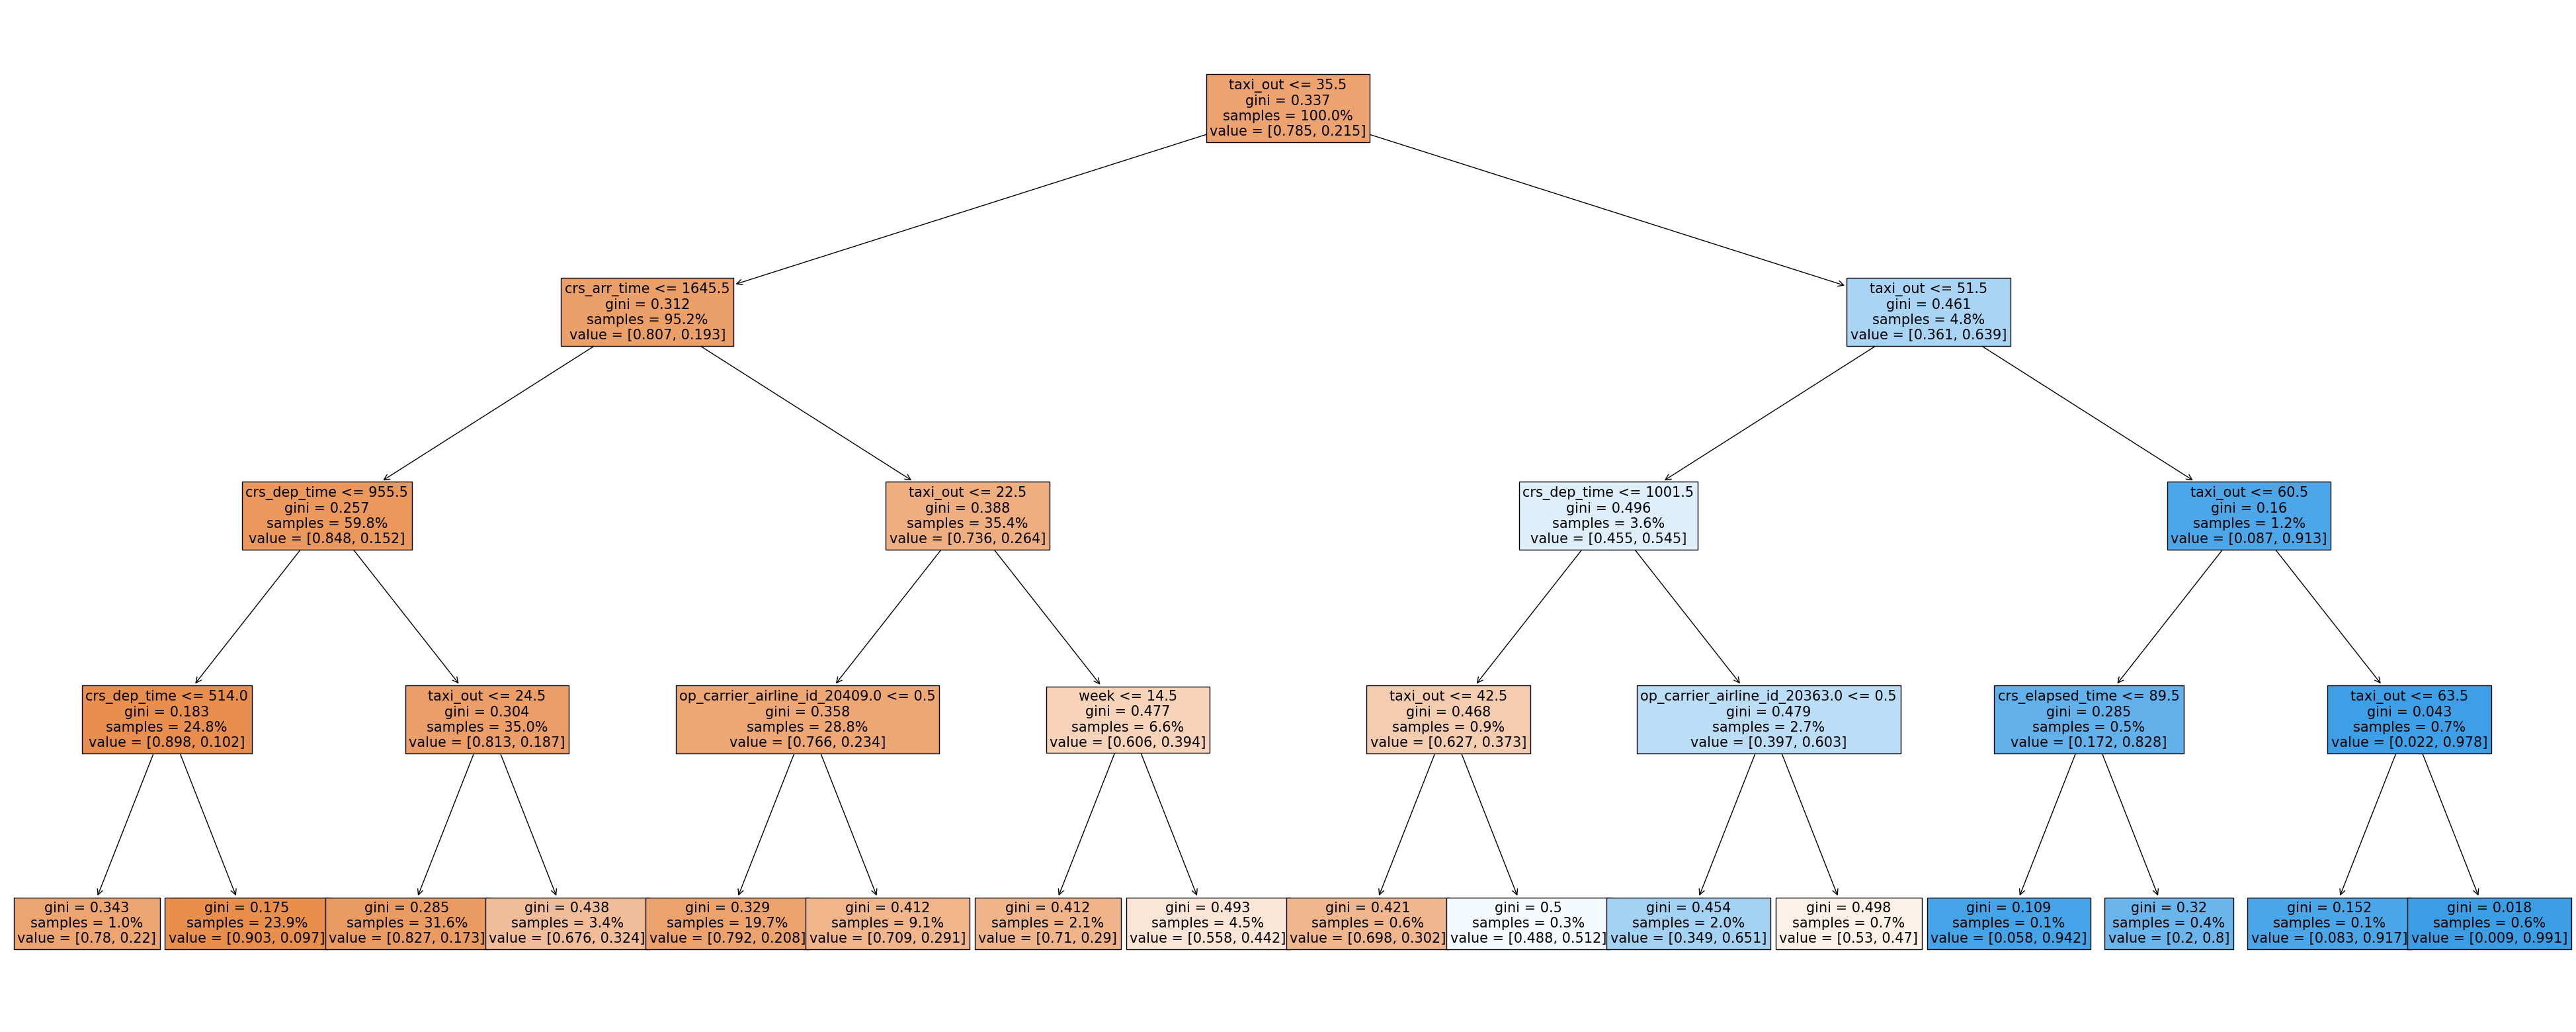

In [58]:
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(model521,ax=ax,fontsize=15,proportion=True,filled=True,feature_names=X_test.columns)

From the visualization of the tree we can see that the most relevant variable is TAXI_OUT. When it takes values hgiher than 35.5, the probability of delay goes from 0.215 to 0.63, and this applies to 4.8% of the cases. If it is higher than 60.5, the probability goes up to 95%.   

Let's take a look at the feature importances of the trained tree

Text(0.5, 0, 'Random Forest Feature Importance')

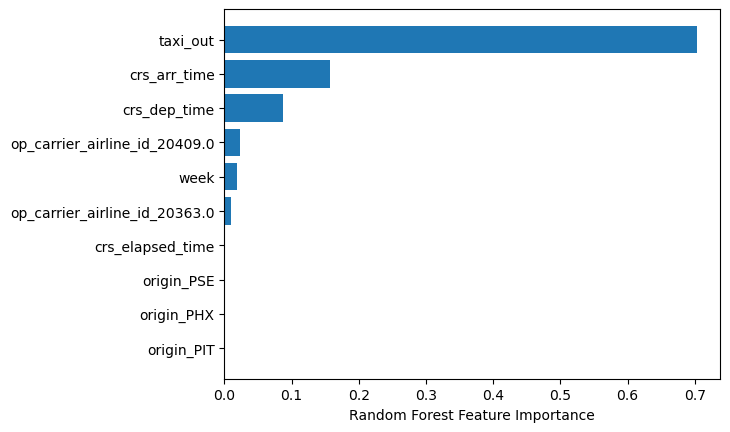

In [ ]:
sorted_idx = model521.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model521.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")

taxi_out is clearly the main feature of the model. We have already seen it's distribution across the target, so it isn't surprising at all.

##### ``5.2.1.2. Hyperparameters optimization``

First of all, the depth.

In [60]:
for i in range(1, 20):
    model521 = DecisionTreeClassifier(max_depth=i, random_state=42)
    model521.fit(X_train, y_train)
    train_accuracy = model521.score(X_train, y_train)
    test_accuracy = model521.score(X_val, y_val)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 2. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 3. Train: 0.8007802993429058 - Test: 0.8005962415488084
Tree max_depth: 4. Train: 0.8012822462886348 - Test: 0.8011463453587209
Tree max_depth: 5. Train: 0.8020123509369677 - Test: 0.8016254680318705
Tree max_depth: 6. Train: 0.803921270382088 - Test: 0.8032402888932266
Tree max_depth: 7. Train: 0.8057997688001947 - Test: 0.8036129398612318
Tree max_depth: 8. Train: 0.8094959235823801 - Test: 0.8038791191240928
Tree max_depth: 9. Train: 0.8130551837430031 - Test: 0.8034532323035153
Tree max_depth: 10. Train: 0.8170555487953274 - Test: 0.8046954021968662
Tree max_depth: 11. Train: 0.8223183864687272 - Test: 0.8032935247457988
Tree max_depth: 12. Train: 0.8289273545874909 - Test: 0.8028676379252214
Tree max_depth: 13. Train: 0.8366999269895352 - Test: 0.7999574113179423
Tree max_depth: 14. Train: 0.8460391822827938 - Test: 0.79951

It is very clear how the tree progressively overfits the data as the max_depth parameter increases. We'll have to make sure that we are pruning the tree to minimize the overfitting. 

Let's change now the min_samples_split, which is the hyperparameter that controls the minimum number of samples (observations) required to split an internal node of the tree.

In [61]:
for i in range(1, 20):
    model521 = DecisionTreeClassifier(max_depth=i, random_state=42,min_samples_split=50)
    model521.fit(X_train, y_train)
    train_accuracy = model521.score(X_train, y_train)
    test_accuracy = model521.score(X_val, y_val)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 2. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 3. Train: 0.8007802993429058 - Test: 0.8005962415488084
Tree max_depth: 4. Train: 0.8012822462886348 - Test: 0.8011463453587209
Tree max_depth: 5. Train: 0.8020123509369677 - Test: 0.8016254680318705
Tree max_depth: 6. Train: 0.8039060598685812 - Test: 0.8032225436090359
Tree max_depth: 7. Train: 0.8056552689218788 - Test: 0.8037549021347576
Tree max_depth: 8. Train: 0.8090776344609394 - Test: 0.8041098078185722
Tree max_depth: 9. Train: 0.8118079216354344 - Test: 0.8038968644082835
Tree max_depth: 10. Train: 0.8140742881479679 - Test: 0.804642166344294
Tree max_depth: 11. Train: 0.8167969700657094 - Test: 0.8041452983869537
Tree max_depth: 12. Train: 0.8197934412265758 - Test: 0.8037903927031391
Tree max_depth: 13. Train: 0.8228127281577026 - Test: 0.8025837133781698
Tree max_depth: 14. Train: 0.8259993307374057 - Test: 0.80208

A maximum depth of 9 and a minimum samples split of 50 will be a good choice. 

In [ ]:
model521 = DecisionTreeClassifier(max_depth=9,random_state=42,min_samples_split=50)
model521.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=50, random_state=42)

In [63]:
print(model521.score(X_train,y_train))
print(model521.score(X_val,y_val))
print(model521.score(X_test,y_test))

0.8118079216354344
0.8038968644082835
0.8128420343117587


It seems the model is far from overfitted.

##### ``5.2.1.3. ROC curve ``

In [64]:
y_test_pred = pd.DataFrame({'DelayPrediction' : model521.predict(X_test), 
                            'DelayScore': model521.predict_proba(X_test)[:,1]},
                            index=y_test.index)
results_df_test = y_test.join(y_test_pred, how= 'inner')
results_df_test['Success'] = (results_df_test[target] == results_df_test['DelayPrediction']).astype(int)

print(metrics.roc_auc_score(results_df_test[target],results_df_test['DelayScore']))

0.7017341775831357


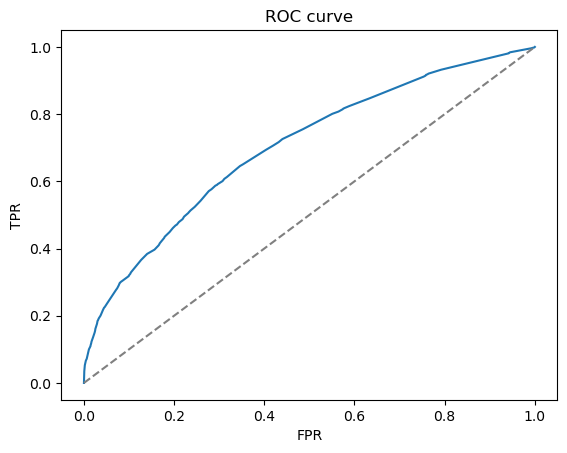

In [65]:
fpr, tpr, _ = metrics.roc_curve(results_df_test[target], results_df_test['DelayScore'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### 5.2.2. Ensembles

##### `5.2.2.1. Random Forest`

In [66]:
model5221 = RandomForestClassifier(n_estimators=3, max_depth=5, random_state=42)

In [67]:
model5221.fit(
    X=X_train, 
    y=np.ravel(y_train)
)

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

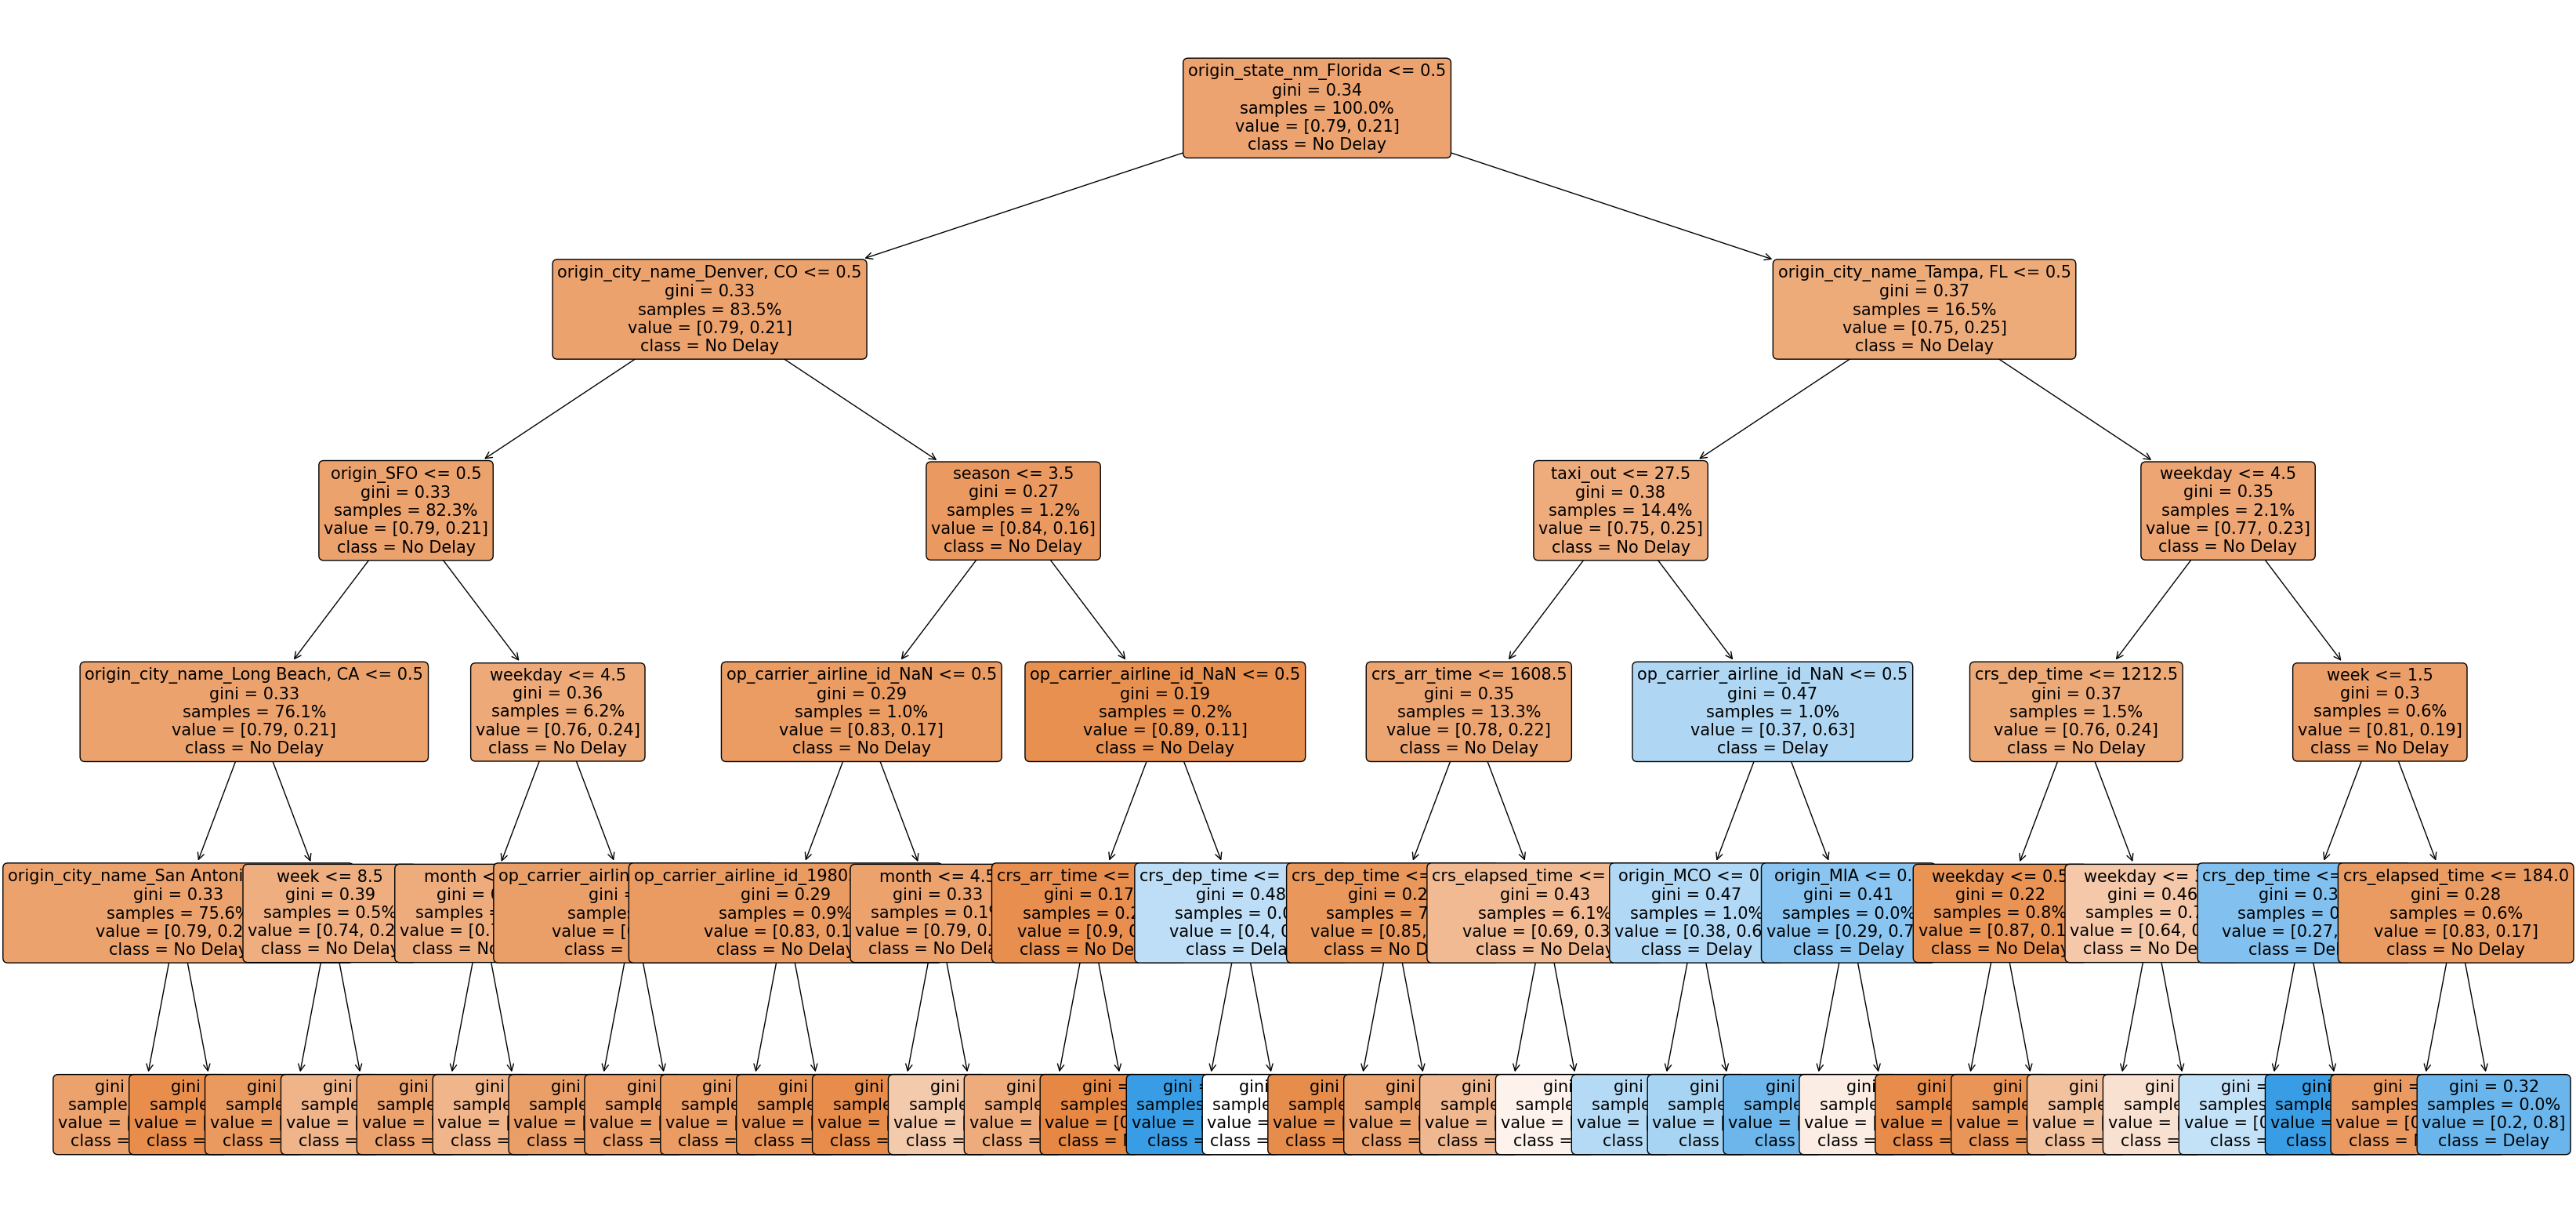

In [68]:
tree_list = model5221.estimators_
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[0], 
               ax = ax, 
               fontsize = 15,
               proportion=True,
               filled = True, 
               impurity=True,
               rounded = True,
               precision = 2,
               class_names = ['No Delay', 'Delay'],
               feature_names = X_test.columns);

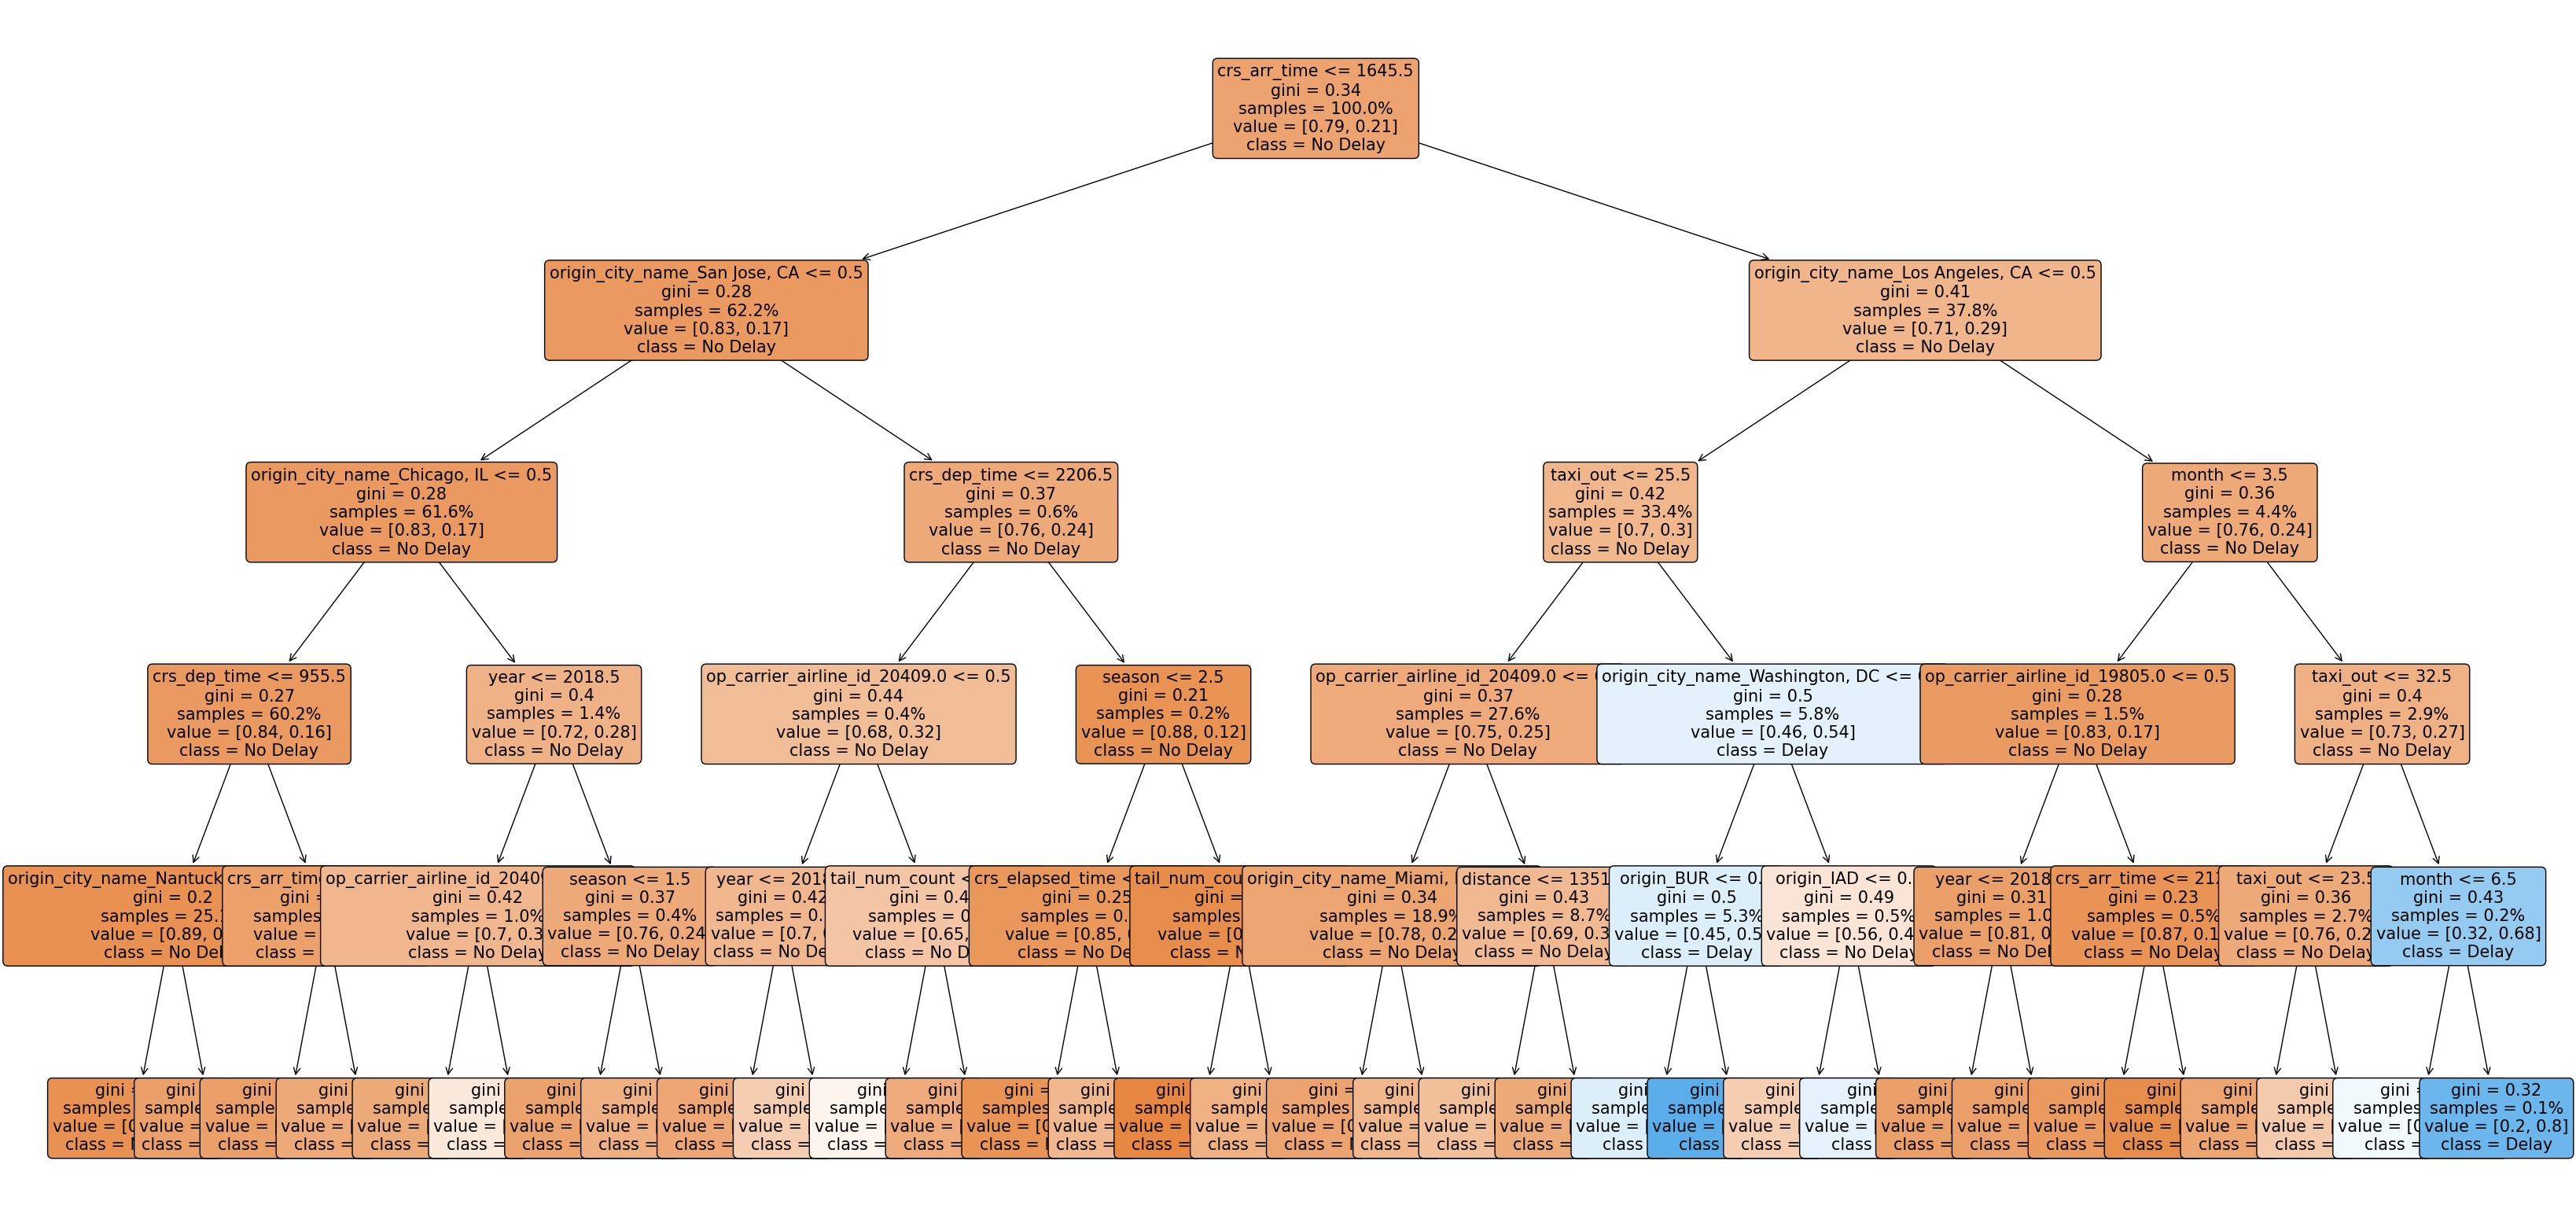

In [69]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[1], 
               ax = ax, 
               fontsize = 15,
               proportion=True,
               filled = True, 
               impurity=True,
               rounded = True,
               precision = 2,
               class_names = ['No Delay', 'Delay'],
               feature_names = X_test.columns);

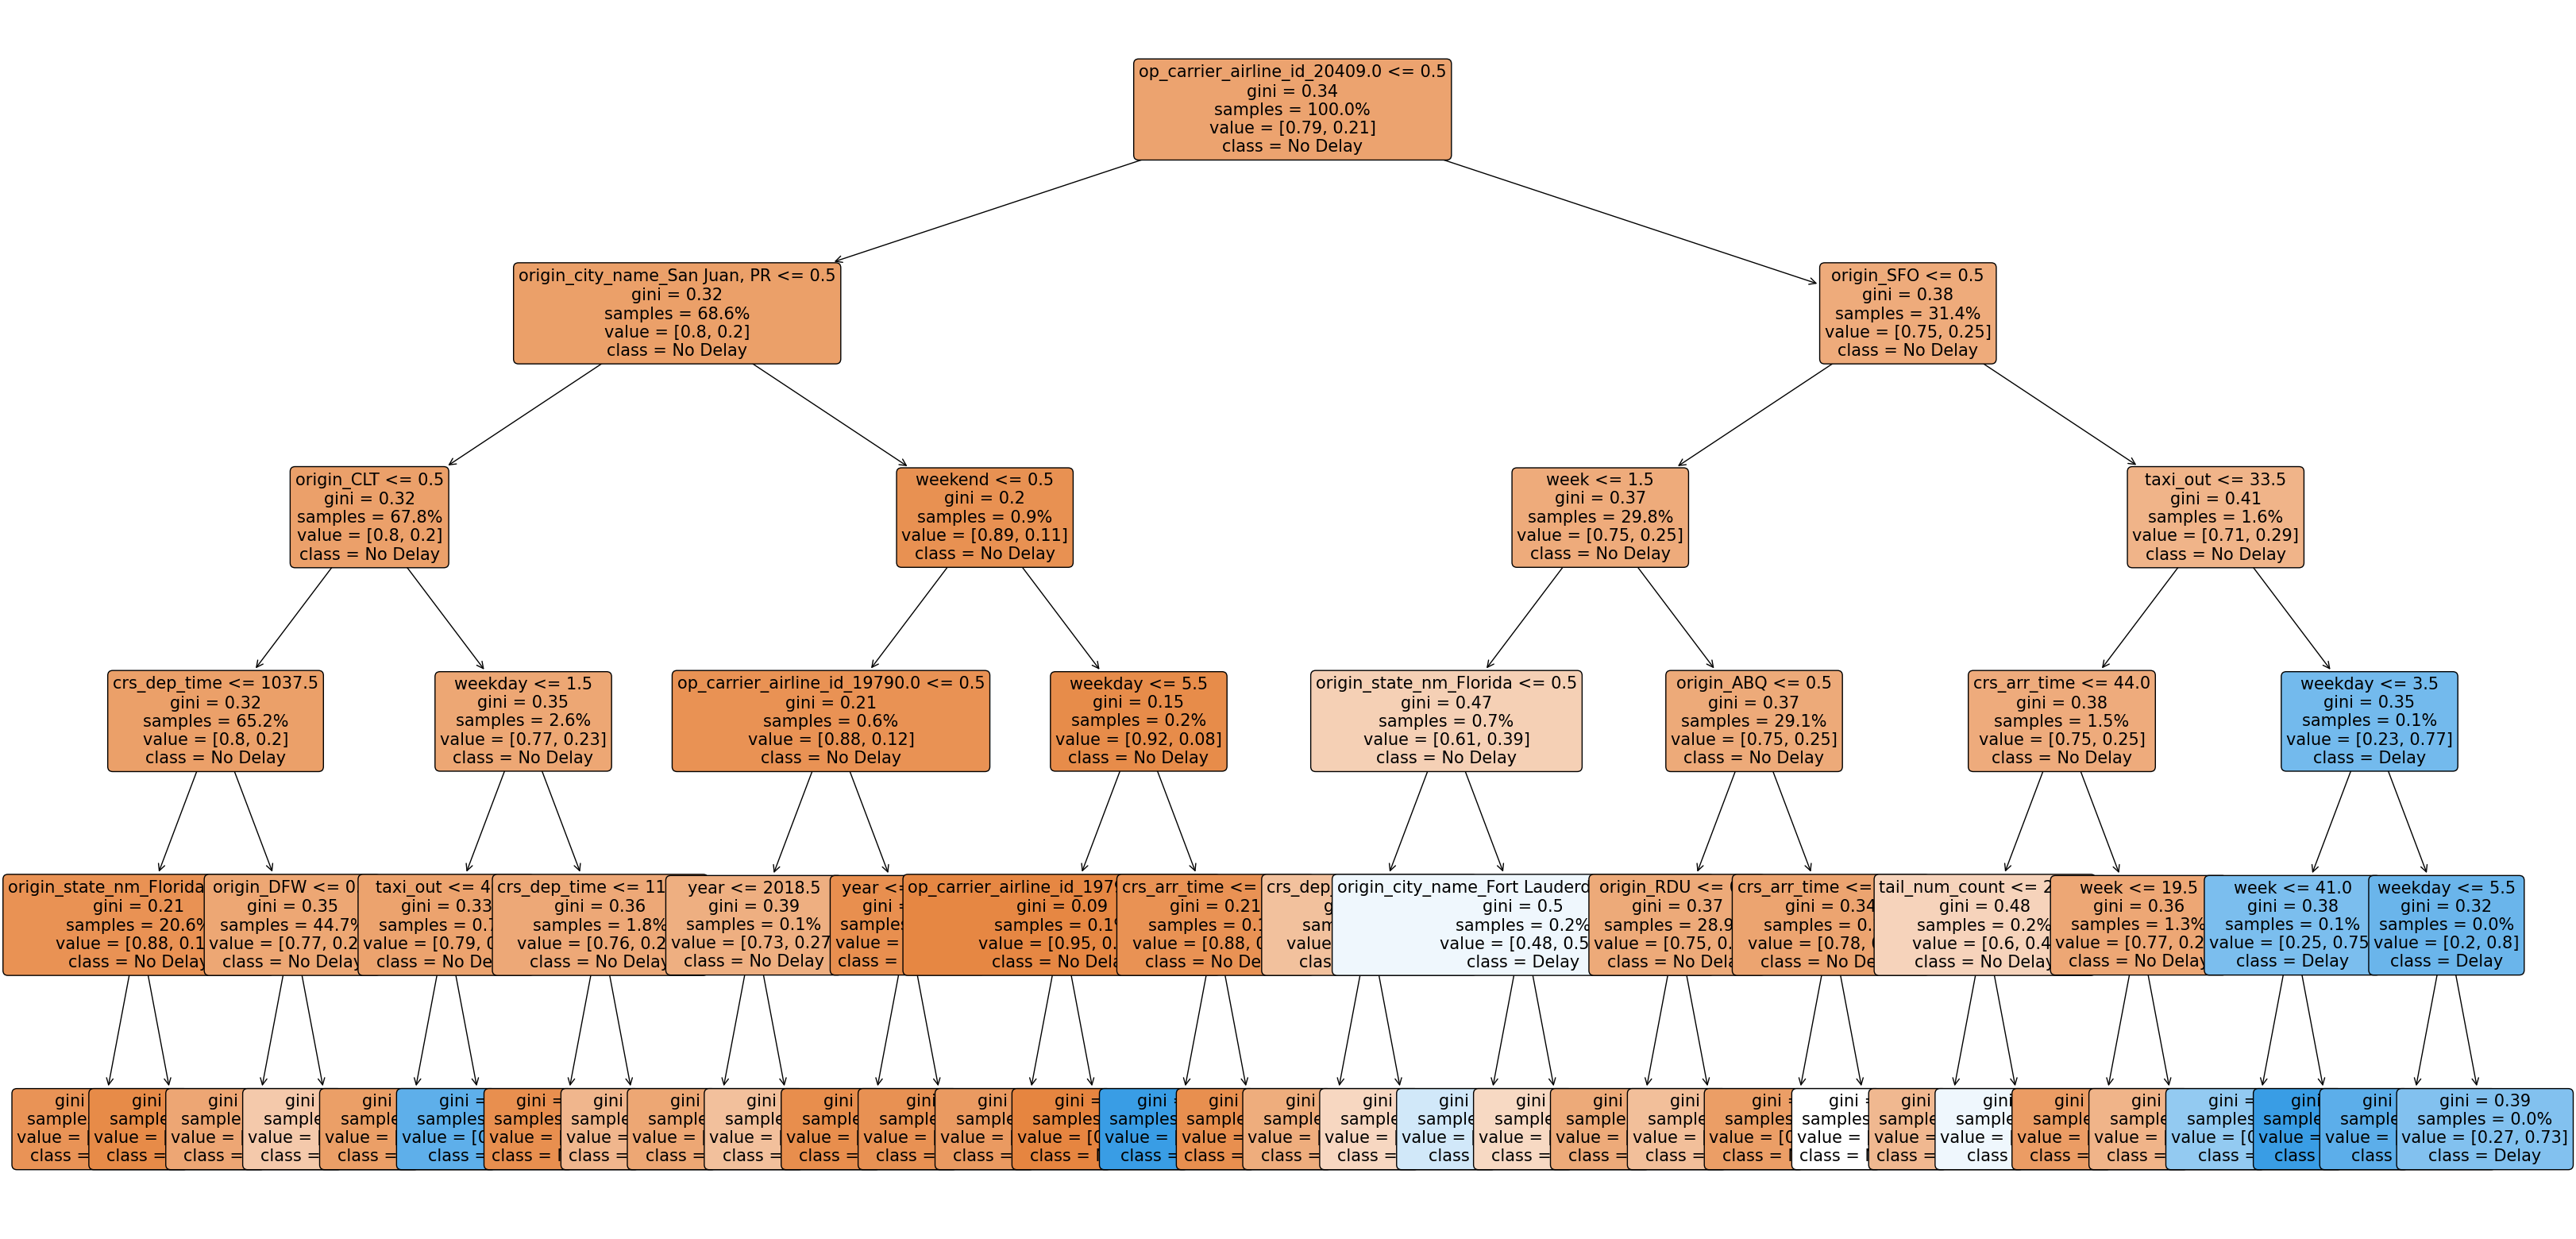

In [70]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[2], 
               ax = ax, 
               fontsize = 15,
               proportion=True,
               filled = True, 
               impurity=True,
               rounded = True,
               precision = 2,
               class_names = ['No Delay', 'Delay'],
               feature_names = X_test.columns);

In [71]:
pd.Series(model5221.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

taxi_out                            0.316552
crs_dep_time                        0.256502
crs_arr_time                        0.202187
op_carrier_airline_id_20409.0       0.075082
origin_state_nm_Florida             0.029204
week                                0.024102
month                               0.012098
origin_DFW                          0.011866
weekday                             0.007834
origin_SFO                          0.007766
crs_elapsed_time                    0.006072
origin_city_name_San Juan, PR       0.005897
origin_city_name_Chicago, IL        0.005472
origin_city_name_Los Angeles, CA    0.004124
origin_city_name_San Antonio, TX    0.004043
distance                            0.003807
origin_RDU                          0.003585
tail_num_count                      0.002717
origin_CLT                          0.002573
origin_city_name_Miami, FL          0.002412
dtype: float64

Let's try with a more complex model.

In [72]:
model5221=RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=500, random_state=42)
model5221.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=8, min_samples_split=500, random_state=42)

And let's predict on validation.

In [73]:
y_score = pd.DataFrame(model5221.predict_proba(X_val)[:,1], index=y_val.index, columns=['DelayScore'])
results_df = y_val.join(y_score)
results_df.head(10)

arr_del15  DelayScore
91964         1.0    0.400401
205250        1.0    0.180412
156190        0.0    0.234639
117192        0.0    0.195565
33706         0.0    0.178810
82783         1.0    0.283557
75723         1.0    0.233006
92264         1.0    0.420934
78746         0.0    0.267148
180918        0.0    0.208696

In [74]:
metrics.roc_auc_score(results_df[target], results_df['DelayScore'])

0.7208166506417245

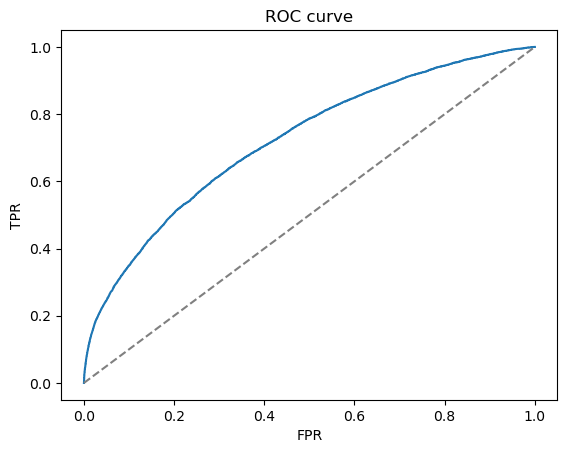

In [75]:
fpr, tpr, _ = metrics.roc_curve(results_df[target], results_df['DelayScore'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Slight difference to the simple decision tree.

##### `5.2.2.2. Gradient Boosting`

In [76]:
model5222=GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
model5222.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [77]:
y_score = pd.DataFrame(model5222.predict_proba(X_val)[:,1], index=y_val.index, columns=['DelayScore'])
results_df = y_val.join(y_score)
metrics.roc_auc_score(results_df[target], results_df['DelayScore'])

0.7483122297729876

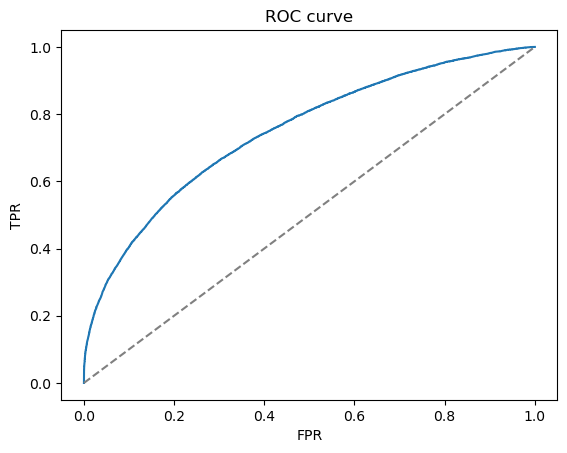

In [78]:
fpr, tpr, _ = metrics.roc_curve(results_df[target], results_df['DelayScore'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### 5.2.3. Model comparison

ROC AUC Score for Decision Tree: 0.716052457429974
ROC AUC Score for Random Forest: 0.7208166506417245
ROC AUC Score for Gradient Boosting: 0.7483122297729876


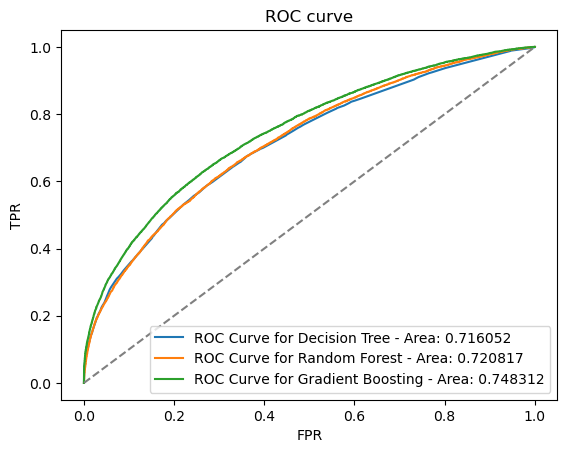

In [79]:
models=[model521,model5221,model5222]
model_names=['Decision Tree','Random Forest', 'Gradient Boosting']
plt.clf()
for i in range (3):
    model=models[i]
    model.fit(X_train, np.ravel(y_train))
    predictions = model.predict_proba(X_val)[:,1]
    auc_score = metrics.roc_auc_score(y_val, predictions)
    print(f'ROC AUC Score for {model_names[i]}: {auc_score}')
    fpr, tpr, _ = metrics.roc_curve(y_val, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_names[i], auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

We can appreciate a slight difference in favor of Gradient Boosting. Although we could have further optimized the hyperparameters, we will consider it as the best model, and therefore, the chosen one to make our final predictions.

## 6. Model evaluation

### ``6.1. Evaluation over train dataset``

#### 6.1.1. Get predictions for the train set

In [80]:
y_train_pred = pd.DataFrame(model5222.predict(X_train), index=y_train.index, columns=['DelayPrediction'])

In [81]:
y_train_pred.head()

DelayPrediction
207503              0.0
96898               0.0
187218              0.0
200201              0.0
80742               0.0

In [82]:
y_train.head()

arr_del15
207503        0.0
96898         0.0
187218        1.0
200201        1.0
80742         0.0

In [83]:
y_train.shape

(131488, 1)

In [84]:
y_train_pred.shape

(131488, 1)

In [85]:
results_df = y_train.join(y_train_pred, how= 'inner')

In [86]:
results_df['Success'] = (results_df[target] == results_df['DelayPrediction']).astype(int)

In [87]:
results_df.head(20)

arr_del15  DelayPrediction  Success
207503        0.0              0.0        1
96898         0.0              0.0        1
187218        1.0              0.0        0
200201        1.0              0.0        0
80742         0.0              0.0        1
122458        0.0              0.0        1
141756        1.0              0.0        0
69088         1.0              1.0        1
178722        0.0              0.0        1
73385         0.0              0.0        1
224633        0.0              0.0        1
102563        0.0              0.0        1
52078         1.0              0.0        0
190908        0.0              0.0        1
42256         0.0              0.0        1
73560         0.0              0.0        1
218289        1.0              0.0        0
198400        0.0              0.0        1
215769        1.0              0.0        0
14319         0.0              0.0        1

In [88]:
print('TRAIN - We have correctly predicted {} from a total of {}. The accuracy is {}.'.format(results_df['Success'].sum(), results_df['Success'].count(), results_df['Success'].mean()))

TRAIN - We have correctly predicted 106885 from a total of 131488. The accuracy is 0.8128878680944268.


It really seems that the model is doing an ok job. But are we being able to predict correctly delayed flights? Or are we rather only predicting correctly non-delayed flights?

#### 6.1.2. Confusion matrix

In [89]:
confusion_matrix = pd.crosstab(results_df[target], results_df['DelayPrediction'])


In [90]:
confusion_matrix

DelayPrediction     0.0   1.0
arr_del15                    
0.0              101395  1844
1.0               22759  5490

In [91]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [92]:
accuracy = (TP + TN) / (TP + TN + FP + FN)

accuracy

0.8128878680944268

In [93]:
Precision = TP / (TP+FP)
Recall = TP/(TP+FN)
print(Precision)
print(Recall)


0.748568311971639
0.1943431625898262


From the total number of positives predicted, 55% are indeed delayed
From the total number of positives in the dataset, I'm only capturing 6% (not good!)

#### 6.1.3. Using the metrics module

In [94]:
confusion_matrix_m = metrics.confusion_matrix(results_df[target],results_df['DelayPrediction'])
Accuracy_m = metrics.accuracy_score(results_df[target], results_df['DelayPrediction'])
Precision_m = metrics.precision_score(results_df[target],results_df['DelayPrediction'])
Recall_m = metrics.recall_score(results_df[target],results_df['DelayPrediction'])

print("Confusion matrix: ", confusion_matrix_m)
print("Accuracy: ", Accuracy_m)
print("Precision: ", Precision_m)
print("Recall: ", Recall_m)


Confusion matrix:  [[101395   1844]
 [ 22759   5490]]
Accuracy:  0.8128878680944268
Precision:  0.748568311971639
Recall:  0.1943431625898262


#### 6.1.4. Using the model

In [95]:
model5222.score(X_test, y_test)

0.8154258477636372

### `6.2. Evaluation over test dataset`


#### 6.2.1. Get predictions for the test set

In [96]:
y_test_pred = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=['DelayPrediction'])

In [97]:
results_df_test = y_test.join(y_test_pred, how= 'inner')
results_df_test['Success'] = (results_df_test[target] == results_df_test['DelayPrediction']).astype(int)

In [98]:
confusion_matrix_m_test = metrics.confusion_matrix(results_df_test[target],results_df_test['DelayPrediction'])
Accuracy_m_test = metrics.accuracy_score(results_df_test[target], results_df_test['DelayPrediction'])
Precision_m_test = metrics.precision_score(results_df_test[target],results_df_test['DelayPrediction'])
Recall_m_test = metrics.recall_score(results_df_test[target],results_df_test['DelayPrediction'])

print("Confusion matrix: ", confusion_matrix_m_test)
print("Accuracy: ", Accuracy_m_test)
print("Precision: ", Precision_m_test)
print("Recall: ", Recall_m_test)


Confusion matrix:  [[48523  1494]
 [10007  2287]]
Accuracy:  0.8154258477636372
Precision:  0.6048664374504099
Recall:  0.18602570359524973


The metrics suggest the following:

- **Confusion Matrix**: A large number of true negatives and a substantial number of false negatives indicate the model is better at predicting the negative class than the positive one.

- **Accuracy**: At 0.81, the model correctly predicts 81% of the outcomes, but this could be misleading if there's class imbalance.

- **Precision**: At 0.60, when the model predicts the positive class, it is correct 60% of the time. This is moderate performance.

- **Recall**: At 0.18, the model only correctly identifies 18% of the actual positive cases, which is quite low and a concern if detecting positives is crucial.

In summary, the model has decent overall accuracy but struggles with recall, indicating room for improvement, especially in identifying the positive class. The model’s effectiveness should be evaluated within the context of its application to determine the next steps for improvement.


#### 6.2.2. ``Extra``: Validation across months (seasonality)

Let's create month and year columns in the results dataset

In [99]:
results_df_test['year'] = X_test['year']
results_df_test['month'] = X_test['month']

In [100]:
results_df_test.head()

arr_del15  DelayPrediction  Success  year  month
120        0.0              0.0        1  2019      8
121        0.0              0.0        1  2019      8
122        0.0              0.0        1  2019      8
123        0.0              0.0        1  2019      8
124        0.0              0.0        1  2019      8

In [101]:
results_df_test.pivot_table(index=['year', 'month'], values='Success', aggfunc=[len, sum, np.mean])

len     sum      mean
           Success Success   Success
year month                          
2019 7       10661    8065  0.756496
     8       10782    8148  0.755704
     9       10120    8650  0.854743
     10      10426    9056  0.868598
     11       9937    8828  0.888397
     12      10385    8063  0.776408

Instead of obtaining the 1/0 predictions from the tree, we can get each register's probability with **predit_proba**. 

In [102]:
y_score = pd.DataFrame(model.predict_proba(X_test)[:,1], index=y_test.index, columns=['DelayScore'])

In [103]:
results_df_test = results_df_test.join(y_score)

In [104]:
results_df_test.head(10)

arr_del15  DelayPrediction  Success  year  month  DelayScore
120        0.0              0.0        1  2019      8    0.148393
121        0.0              0.0        1  2019      8    0.411755
122        0.0              0.0        1  2019      8    0.345090
123        0.0              0.0        1  2019      8    0.126042
124        0.0              0.0        1  2019      8    0.339363
125        0.0              0.0        1  2019      8    0.179120
126        0.0              0.0        1  2019      8    0.402962
127        0.0              0.0        1  2019      8    0.244007
128        0.0              1.0        0  2019      8    0.541794
129        0.0              0.0        1  2019      8    0.120456

## 7. Feature engineering `(3/12/2024):`

### 7.3. Adding if previous flight was delayed

In [90]:
df = df_before_data_prep.copy()

In [91]:
df.shape

(250152, 12)

In [92]:
df['fl_date'] = pd.to_datetime(df['fl_date'], unit='ms')
df = df.sort_values(by=['fl_date', 'origin', 'crs_dep_time'])

In [ ]:
df['prev_delays'] = (
    df.groupby(['fl_date', 'origin'])['arr_del15']
    .apply(lambda x: x.cumsum().shift(1).fillna(0).astype(int))
    .reset_index(drop=True)
)

In [46]:
df.prev_delays.value_counts().head()

prev_delays
0    156931
1     46916
2     19403
3      9697
4      5404
Name: count, dtype: int64

Now let's repeat same steps in order to compare with the original dataset

### 7.4. Data preparation

In [47]:
df.select_dtypes(include=['object']).describe().T

count unique              top     freq
op_carrier_airline_id  250152.0   12.0          20409.0  78587.0
tail_num                 250152   2646              NaN    15009
origin                   250152     72              LAX    25345
origin_city_name         250152     70  Los Angeles, CA    25345
origin_state_nm          250152     32       California    51137

In [48]:
aux=pd.get_dummies(df[['op_carrier_airline_id','origin','origin_city_name','origin_state_nm']])
df=pd.concat([df,aux],axis=1)
df.drop(columns=['op_carrier_airline_id','origin','origin_city_name','origin_state_nm'],inplace=True)
df.shape

(250152, 195)

In [49]:
df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)

C:\Users\diego\AppData\Local\Temp\ipykernel_21868\3894922256.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)
C:\Users\diego\AppData\Local\Temp\ipykernel_21868\3894922256.py:1: FutureWarning: The provided callable <function mean at 0x000002AEB24BD440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)


len       sum      mean
         arr_del15 arr_del15 arr_del15
tail_num                              
NaN          15009    3109.0  0.207142
N110AN         761     164.0  0.215506
N113AN         751     134.0  0.178429
N111ZM         748     162.0  0.216578
N109NN         740     118.0  0.159459
...            ...       ...       ...
N745VJ           1       0.0  0.000000
N744P            1       0.0  0.000000
N734AR           1       0.0  0.000000
N733AR           1       0.0  0.000000
N719AN           1       0.0  0.000000

[2646 rows x 3 columns]

In [50]:
df_tail_num = pd.DataFrame(df['tail_num'].value_counts(dropna = False))
df_tail_num.columns = ['tail_num_count']

In [51]:
df = df.merge(df_tail_num,on='tail_num')    

In [52]:
df.drop('tail_num',axis=1,inplace=True)

In [53]:
df['fl_date'].dtypes

dtype('<M8[ns]')

In [54]:
df['fl_date'] = pd.to_datetime(df['fl_date'])
df['season'] = df['fl_date'].dt.quarter
df['year'] = df['fl_date'].dt.year
df['month'] = df['fl_date'].dt.month
df['weekday'] = df['fl_date'].dt.weekday

In [55]:
df.head()

fl_date  crs_dep_time  taxi_out  crs_arr_time  arr_del15  \
0 2018-01-01          2359       9.0           552        0.0   
1 2018-01-01           815      -1.0          1030        0.0   
2 2018-01-01          1030      44.0          1245        1.0   
3 2018-01-01          1206      12.0          1426        0.0   
4 2018-01-01          1529      14.0          1755        0.0   

   crs_elapsed_time  distance  prev_delays  op_carrier_airline_id_19690.0  \
0             233.0    1826.0            0                          False   
1             135.0     760.0            0                          False   
2             135.0     760.0            0                          False   
3             140.0     760.0            0                          False   
4             146.0     760.0            0                          False   

   op_carrier_airline_id_19790.0  ...  origin_state_nm_Utah  \
0                          False  ...                 False   
1                           True  ...                 False   
2                           True  ...                 False   
3                           True  ...                 False   
4                           True  ...                 False   

   origin_state_nm_Vermont  origin_state_nm_Virginia  \
0                    False                     False   
1                    False                     False   
2                    False                     False   
3                    False                     False   
4                    False                     False   

   origin_state_nm_Washington  origin_state_nm_Wyoming  tail_num_count  \
0                       False                    False             267   
1                       False                    False               1   
2                       False                    False               5   
3                       False                    False             177   
4                       False                    False               1   

   season  year  month  weekday  
0       1  2018      1        0  
1       1  2018      1        0  
2       1  2018      1        0  
3       1  2018      1        0  
4       1  2018      1        0  

[5 rows x 199 columns]

In [56]:
df['weekend']=(df['weekday']>=5).astype(int)

In [57]:
df.drop(columns=['fl_date'],inplace=True)

### 7.5. Modelling

In [58]:
df.pivot_table(index=['year','month'], values='arr_del15', aggfunc=[len, sum, np.mean])

C:\Users\diego\AppData\Local\Temp\ipykernel_21868\1444551352.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.pivot_table(index=['year','month'], values='arr_del15', aggfunc=[len, sum, np.mean])
C:\Users\diego\AppData\Local\Temp\ipykernel_21868\1444551352.py:1: FutureWarning: The provided callable <function mean at 0x000002AEB24BD440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.pivot_table(index=['year','month'], values='arr_del15', aggfunc=[len, sum, np.mean])


len       sum      mean
           arr_del15 arr_del15 arr_del15
year month                              
2018 1          9244    1968.0  0.212895
     2          9115    1418.0  0.155568
     3          9927    1825.0  0.183842
     4         10393    2184.0  0.210141
     5         10915    2478.0  0.227027
     6         11052    2504.0  0.226565
     7         11201    3463.0  0.309169
     8         11202    3345.0  0.298607
     9         10591    2304.0  0.217543
     10        10952    1628.0  0.148649
     11        10194    2138.0  0.209731
     12        10697    2199.0  0.205572
2019 1         10245    2154.0  0.210249
     2          9381    1817.0  0.193689
     3         11084    1812.0  0.163479
     4         10308    2236.0  0.216919
     5         10797    2122.0  0.196536
     6         10543    2743.0  0.260173
     7         10661    2735.0  0.256543
     8         10782    2912.0  0.270080
     9         10120    1544.0  0.152569
     10        10426    1418.0  0.136006
     11         9937    1205.0  0.121264
     12        10385    2480.0  0.238806

In [59]:
train=df[(df.year==2018) | (df.month<7)]
test=df[(df.year==2019) & (df.month>6)]
train.shape,test.shape

((187841, 199), (62311, 199))

In [60]:
X_train_=train.drop(target,axis=1)
y_train_=train[[target]]
X_test=test.drop(target,axis=1)
y_test=test[[target]]

In [61]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_, y_train_,test_size = 0.30, random_state = 42)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((131488, 198), (56353, 198), (131488, 1), (56353, 1))

#### 5.2.1. Decision Tree

##### `5.2.1.1. First training and feature importance`

In [64]:
model521 = DecisionTreeClassifier(max_depth=4,random_state=42)

In [65]:
model521.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

[Text(0.5, 0.9, 'taxi_out <= 34.5\ngini = 0.336\nsamples = 100.0%\nvalue = [0.786, 0.214]'),
 Text(0.25, 0.7, 'crs_arr_time <= 1645.5\ngini = 0.31\nsamples = 94.7%\nvalue = [0.809, 0.191]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'crs_dep_time <= 955.5\ngini = 0.255\nsamples = 59.5%\nvalue = [0.85, 0.15]'),
 Text(0.0625, 0.3, 'crs_dep_time <= 514.0\ngini = 0.181\nsamples = 24.8%\nvalue = [0.899, 0.101]'),
 Text(0.03125, 0.1, 'gini = 0.353\nsamples = 1.0%\nvalue = [0.771, 0.229]'),
 Text(0.09375, 0.1, 'gini = 0.172\nsamples = 23.8%\nvalue = [0.905, 0.095]'),
 Text(0.1875, 0.3, 'taxi_out <= 21.5\ngini = 0.302\nsamples = 34.8%\nvalue = [0.815, 0.185]'),
 Text(0.15625, 0.1, 'gini = 0.278\nsamples = 29.4%\nvalue = [0.833, 0.167]'),
 Text(0.21875, 0.1, 'gini = 0.409\nsamples = 5.4%\nvalue = [0.714, 0.286]'),
 Text(0.375, 0.5, 'taxi_out <= 22.5\ngini = 0.386\nsamples = 35.2%\nvalue = [0.739, 0.261]'),
 Text(0.3125, 0.3, 'op_carrier_airline_id_20409.0 <= 0.5\ngini = 0.358\nsamples = 28

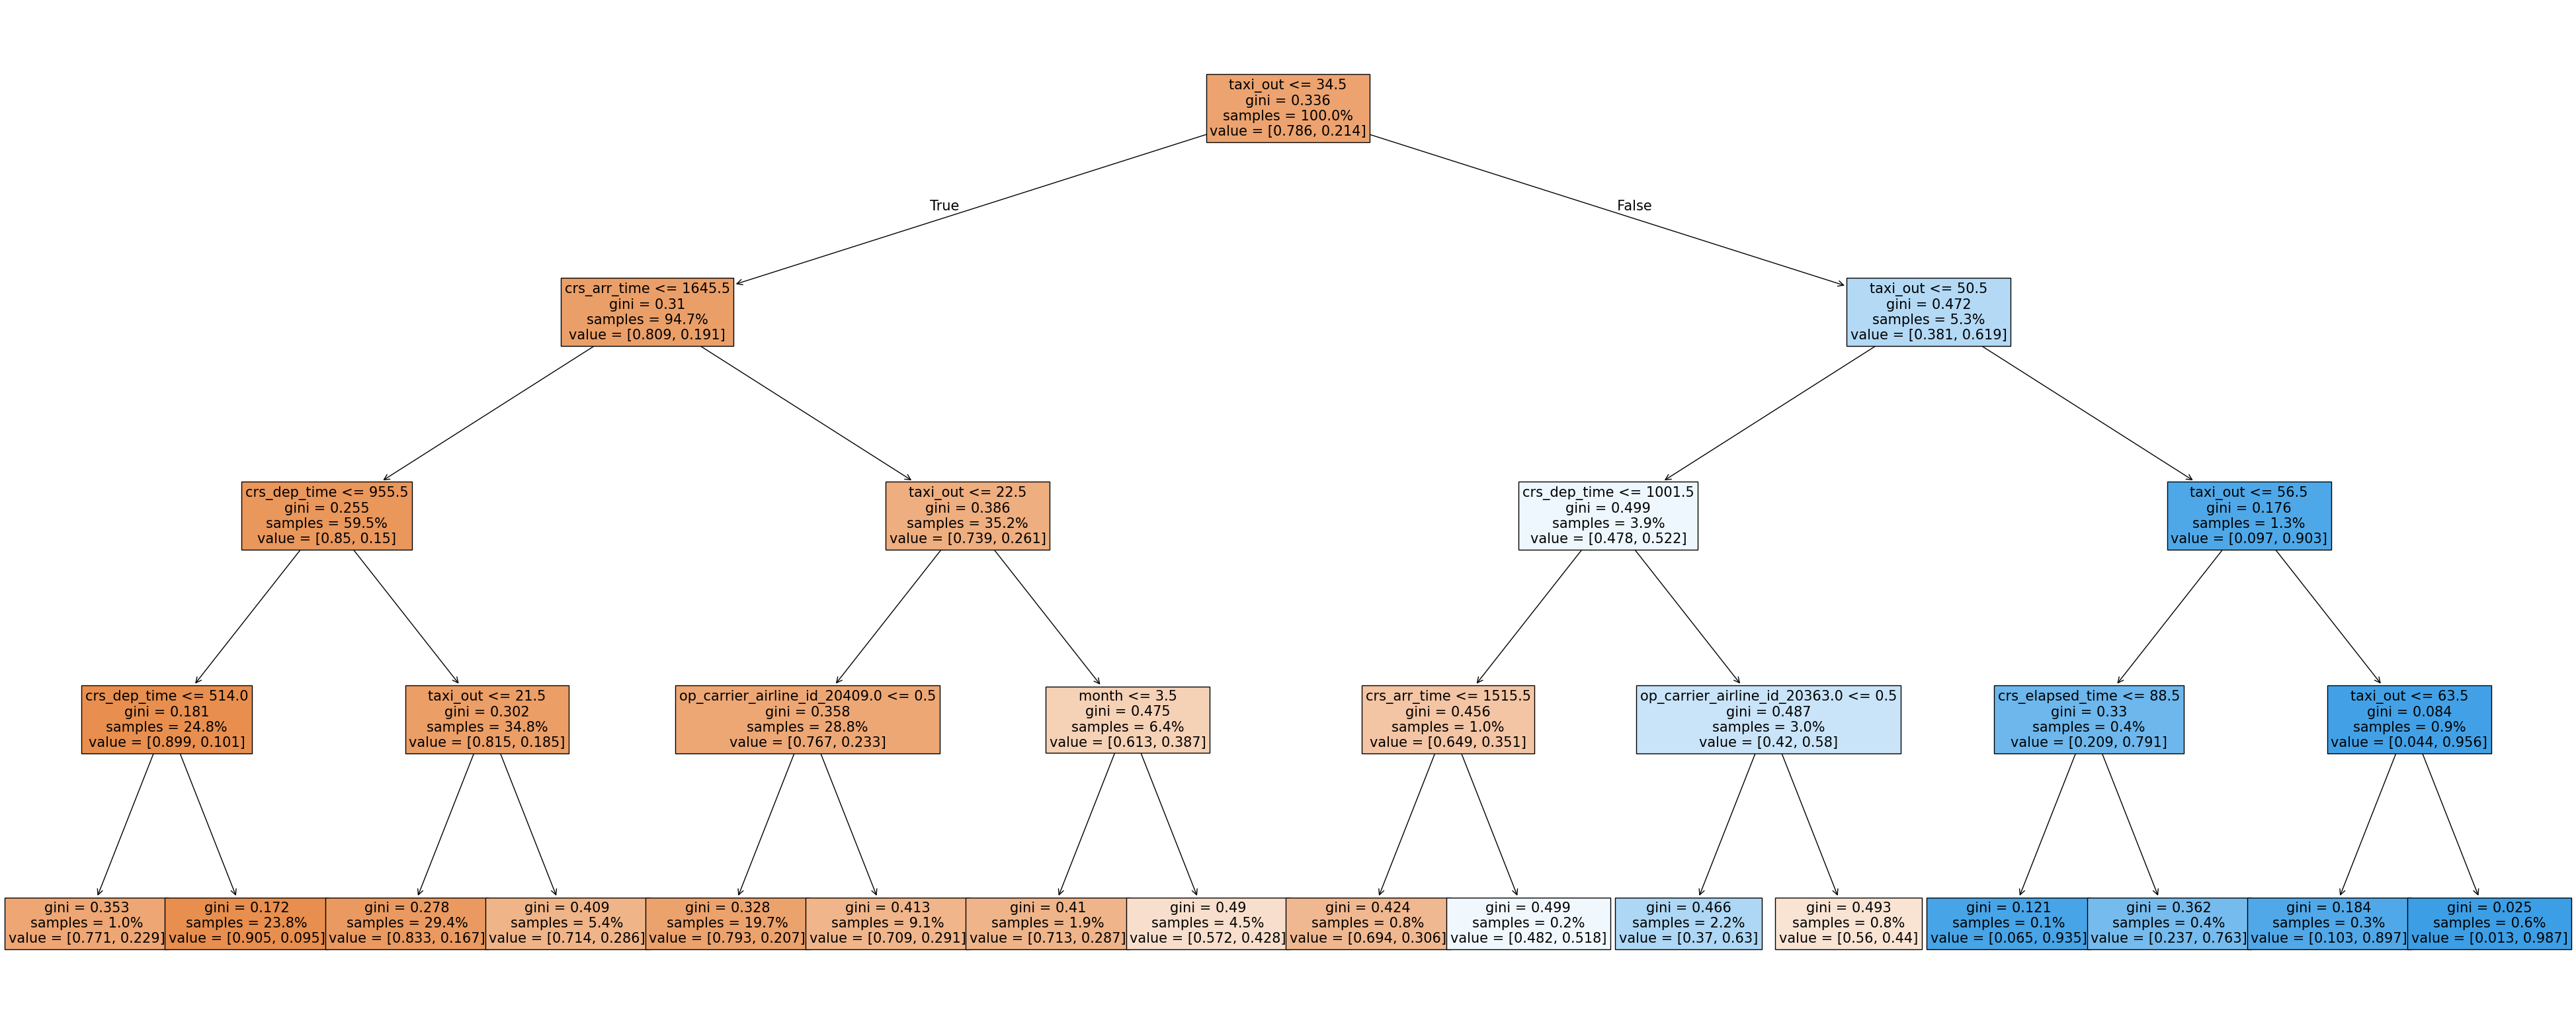

In [66]:
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(model521,ax=ax,fontsize=15,proportion=True,filled=True,feature_names=X_test.columns)

Let's take a look at the feature importances of the trained tree

Text(0.5, 0, 'Random Forest Feature Importance')

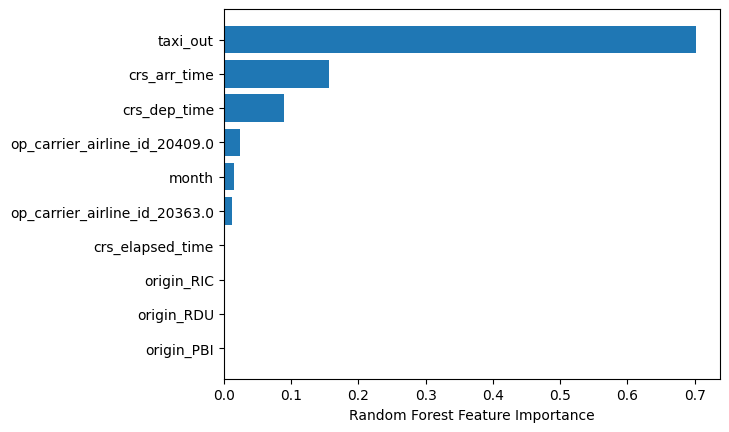

In [68]:
sorted_idx = model521.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model521.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")

We can not see any difference in terms of adding previous delayed flights in the airport.

##### ``5.2.1.2. Hyperparameters optimization``

In [69]:
for i in range(1, 20):
    model521 = DecisionTreeClassifier(max_depth=i, random_state=42)
    model521.fit(X_train, y_train)
    train_accuracy = model521.score(X_train, y_train)
    test_accuracy = model521.score(X_val, y_val)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.7985443538573862 - Test: 0.7950952034496832
Tree max_depth: 2. Train: 0.7985443538573862 - Test: 0.7950952034496832
Tree max_depth: 3. Train: 0.8014799829642248 - Test: 0.7984490621617305
Tree max_depth: 4. Train: 0.8024990873691896 - Test: 0.7990169112558337
Tree max_depth: 5. Train: 0.803921270382088 - Test: 0.7999574113179423
Tree max_depth: 6. Train: 0.8048034801654904 - Test: 0.7997622131918443
Tree max_depth: 7. Train: 0.8065450839620345 - Test: 0.8002235905808032
Tree max_depth: 8. Train: 0.8086137137989778 - Test: 0.7997622131918443
Tree max_depth: 9. Train: 0.8109181065952786 - Test: 0.7996557414866999
Tree max_depth: 10. Train: 0.8142111827695303 - Test: 0.799070147108406
Tree max_depth: 11. Train: 0.8194816256996836 - Test: 0.7963906091956062
Tree max_depth: 12. Train: 0.8262122779265028 - Test: 0.7945450996397707
Tree max_depth: 13. Train: 0.8341673764906303 - Test: 0.7909428069490533
Tree max_depth: 14. Train: 0.8436815526892187 - Test: 0.786701

In [71]:
for i in range(1, 20):
    model521 = DecisionTreeClassifier(max_depth=i, random_state=42,min_samples_split=50)
    model521.fit(X_train, y_train)
    train_accuracy = model521.score(X_train, y_train)
    test_accuracy = model521.score(X_val, y_val)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.7985443538573862 - Test: 0.7950952034496832
Tree max_depth: 2. Train: 0.7985443538573862 - Test: 0.7950952034496832
Tree max_depth: 3. Train: 0.8014799829642248 - Test: 0.7984490621617305
Tree max_depth: 4. Train: 0.8024990873691896 - Test: 0.7990169112558337
Tree max_depth: 5. Train: 0.803921270382088 - Test: 0.7999574113179423
Tree max_depth: 6. Train: 0.8047958749087369 - Test: 0.7997977037602257
Tree max_depth: 7. Train: 0.8064081893404721 - Test: 0.8003123170017568
Tree max_depth: 8. Train: 0.8081650036505232 - Test: 0.8000816283072774
Tree max_depth: 9. Train: 0.8098533706497931 - Test: 0.7996025056341277
Tree max_depth: 10. Train: 0.8116862375273789 - Test: 0.7993718169396483
Tree max_depth: 11. Train: 0.8147055244585057 - Test: 0.7967810054478023
Tree max_depth: 12. Train: 0.8179149428084692 - Test: 0.7957872695331216
Tree max_depth: 13. Train: 0.8205995984424435 - Test: 0.7931254769045126
Tree max_depth: 14. Train: 0.8233755171574593 - Test: 0.79112

There are no significant changes

In [72]:
model521 = DecisionTreeClassifier(max_depth=9,random_state=42,min_samples_split=50)
model521.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=50, random_state=42)

In [73]:
print(model521.score(X_train,y_train))
print(model521.score(X_val,y_val))
print(model521.score(X_test,y_test))

0.8098533706497931
0.7996025056341277
0.8155702845404503


##### ``5.2.1.3. ROC curve ``

In [74]:
y_test_pred = pd.DataFrame({'DelayPrediction' : model521.predict(X_test), 
                            'DelayScore': model521.predict_proba(X_test)[:,1]},
                            index=y_test.index)
results_df_test = y_test.join(y_test_pred, how= 'inner')
results_df_test['Success'] = (results_df_test[target] == results_df_test['DelayPrediction']).astype(int)

print(metrics.roc_auc_score(results_df_test[target],results_df_test['DelayScore']))

0.7002685542097076


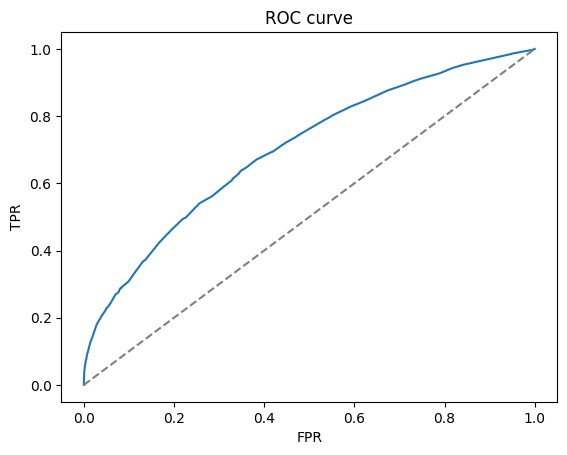

In [75]:
fpr, tpr, _ = metrics.roc_curve(results_df_test[target], results_df_test['DelayScore'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### 5.2.2. Ensembles

##### `5.2.2.1. Random Forest`

In [76]:
model5221 = RandomForestClassifier(n_estimators=3, max_depth=5, random_state=42)

In [77]:
model5221.fit(
    X=X_train, 
    y=np.ravel(y_train)
)

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

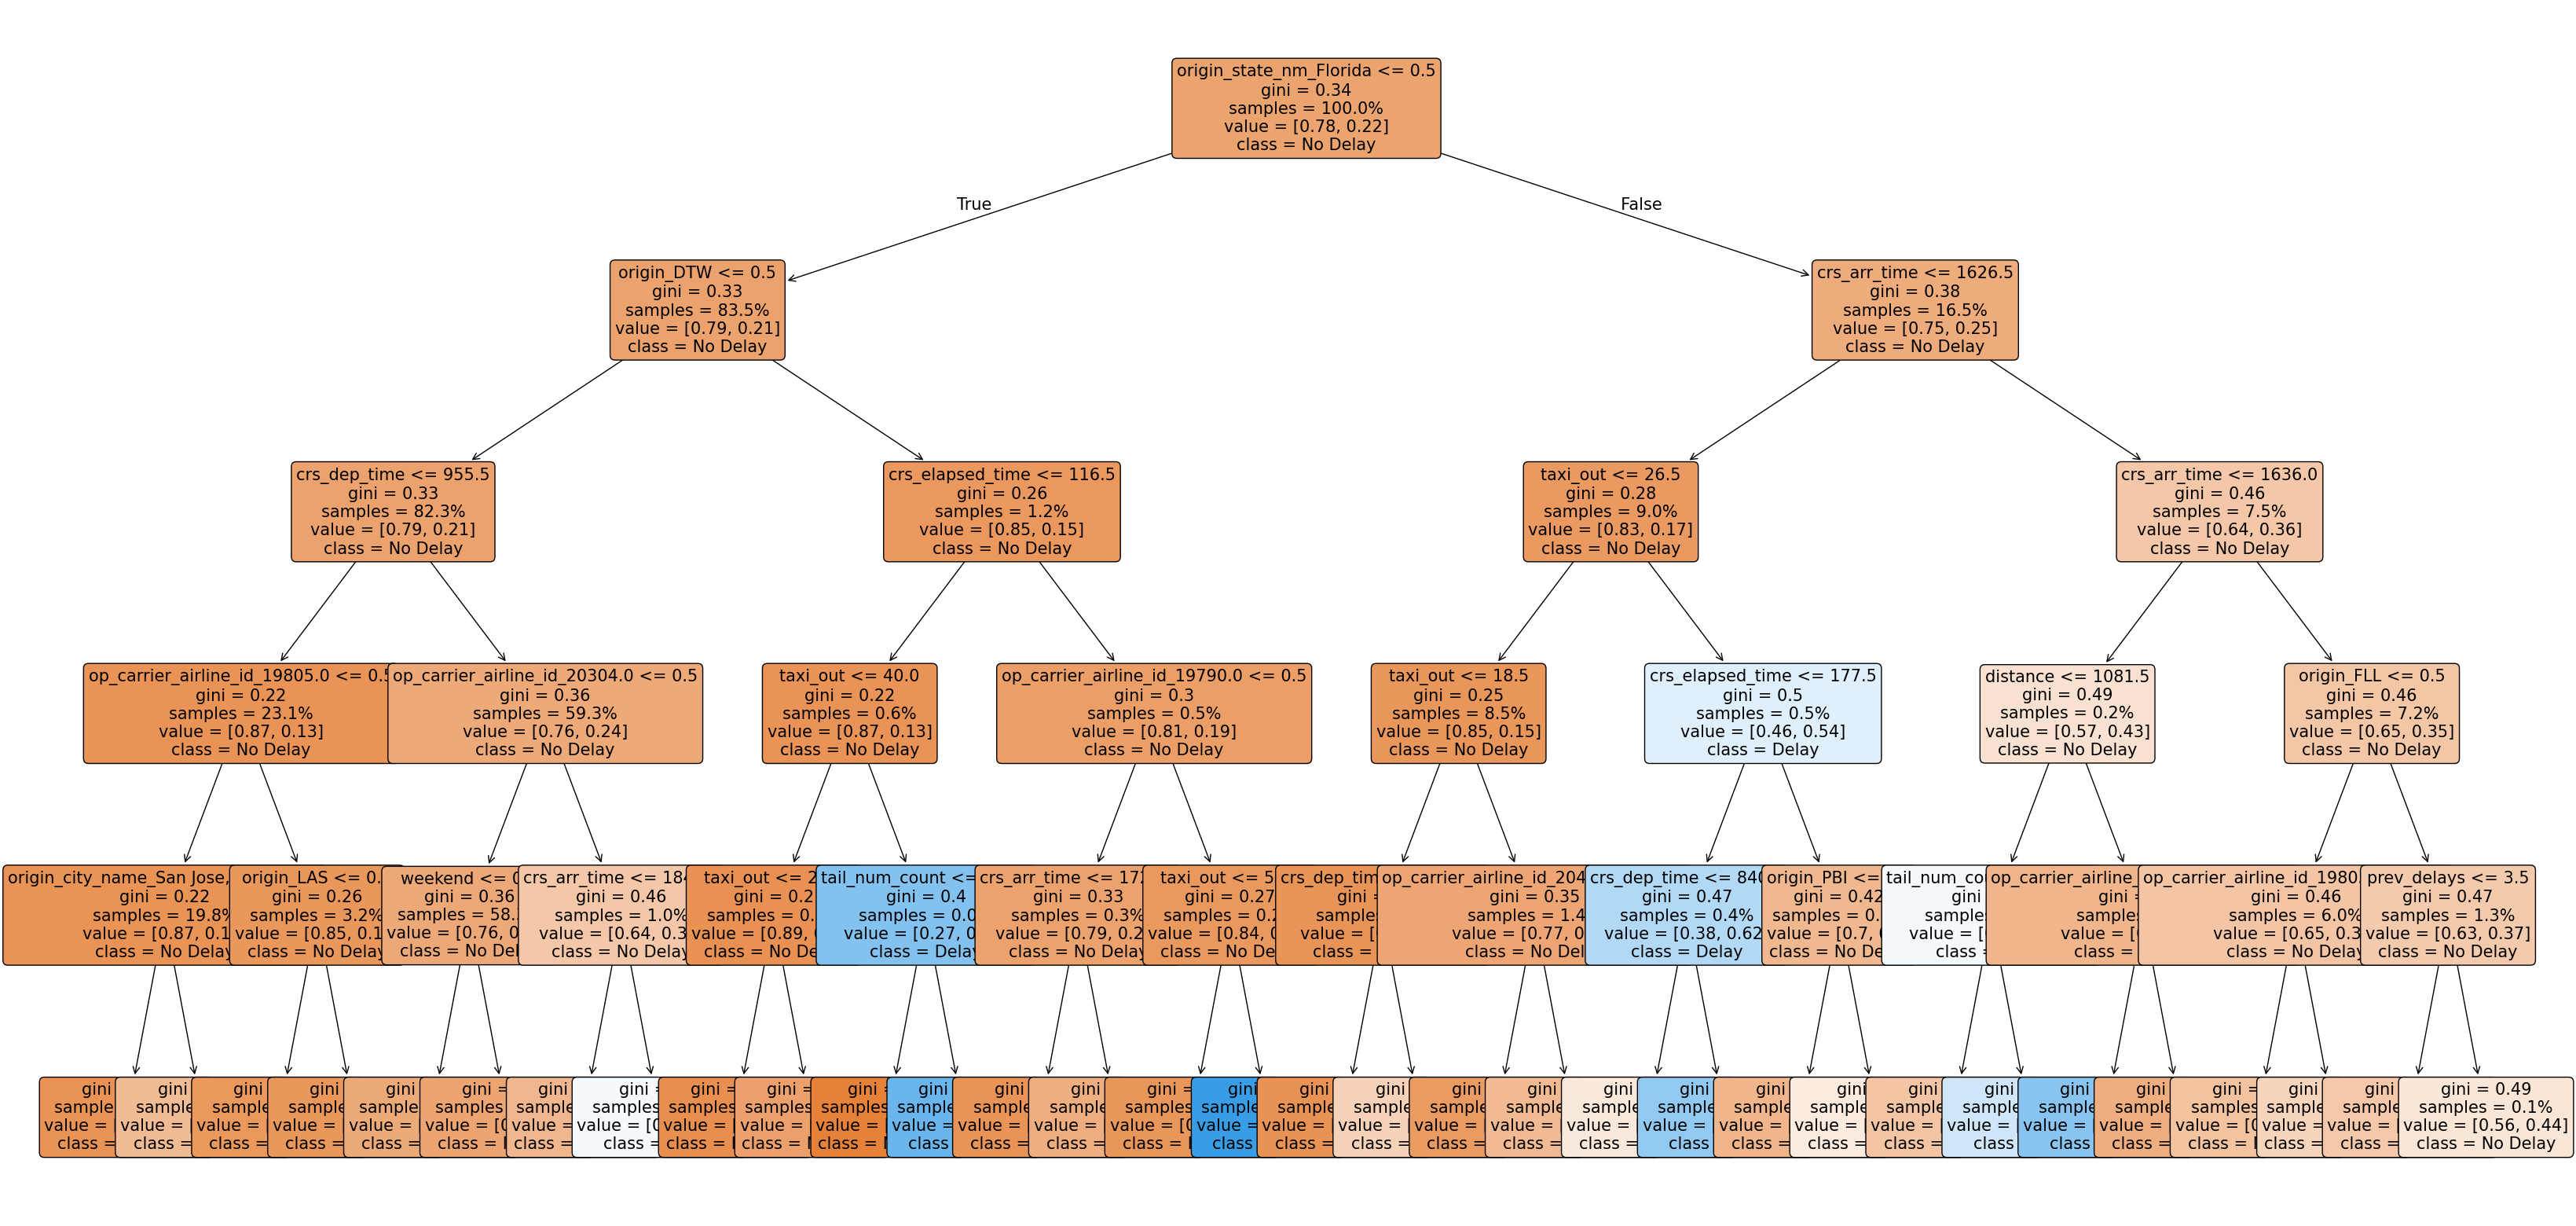

In [78]:
tree_list = model5221.estimators_
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[0], 
               ax = ax, 
               fontsize = 15,
               proportion=True,
               filled = True, 
               impurity=True,
               rounded = True,
               precision = 2,
               class_names = ['No Delay', 'Delay'],
               feature_names = X_test.columns);

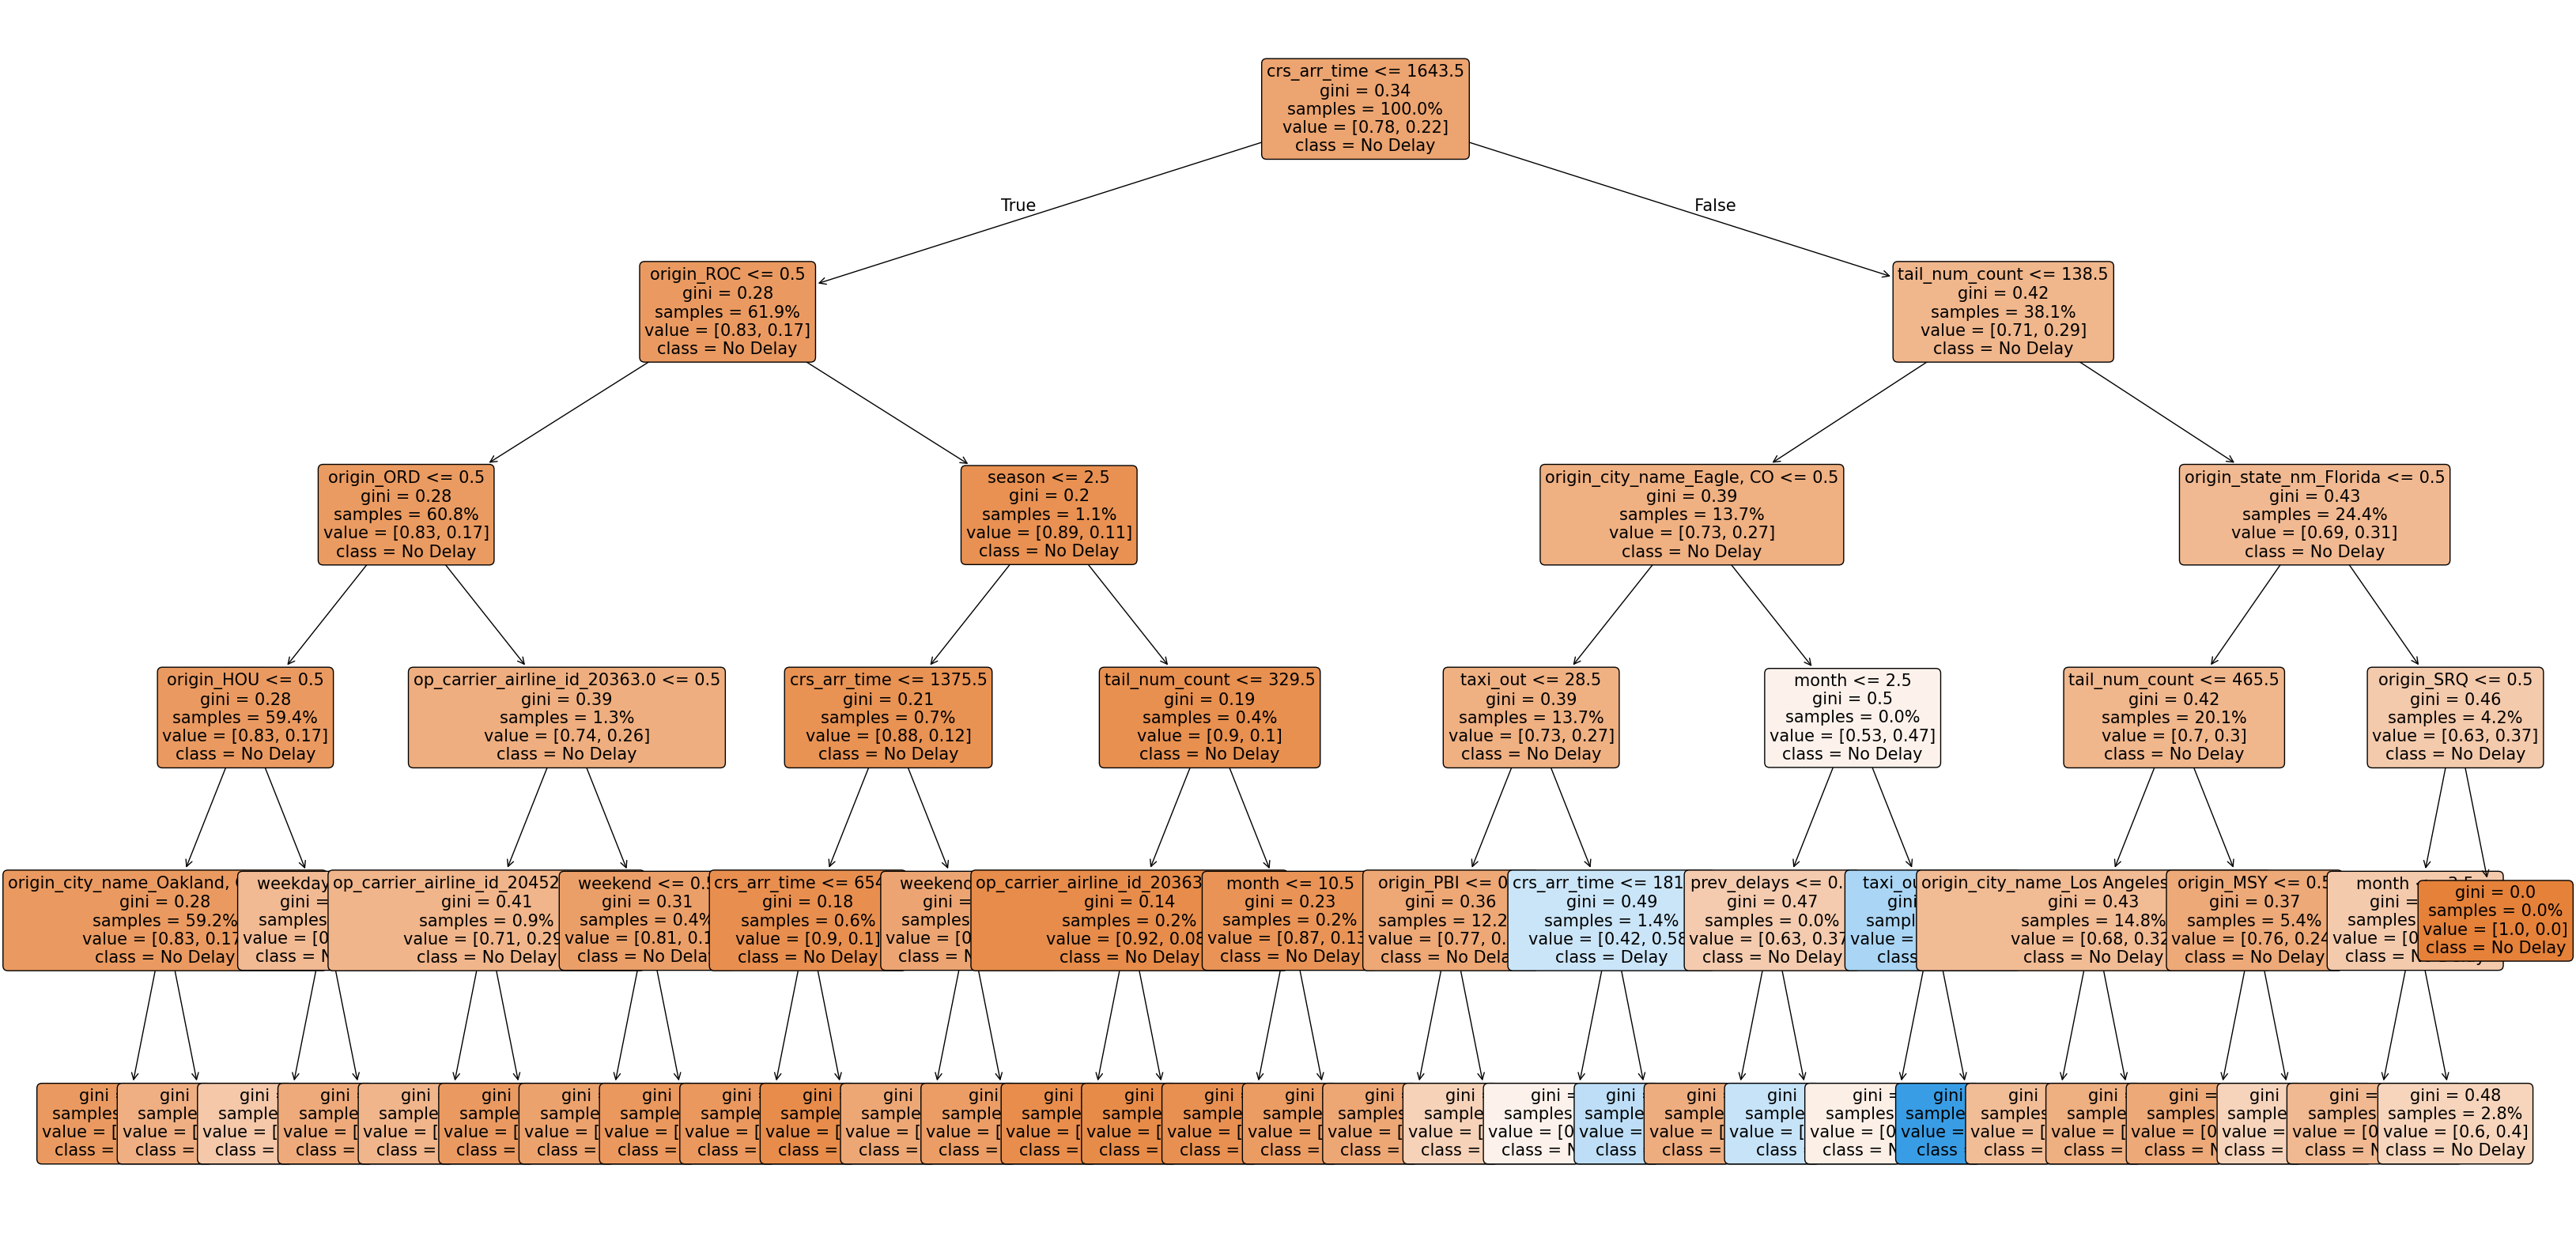

In [79]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[1], 
               ax = ax, 
               fontsize = 15,
               proportion=True,
               filled = True, 
               impurity=True,
               rounded = True,
               precision = 2,
               class_names = ['No Delay', 'Delay'],
               feature_names = X_test.columns);

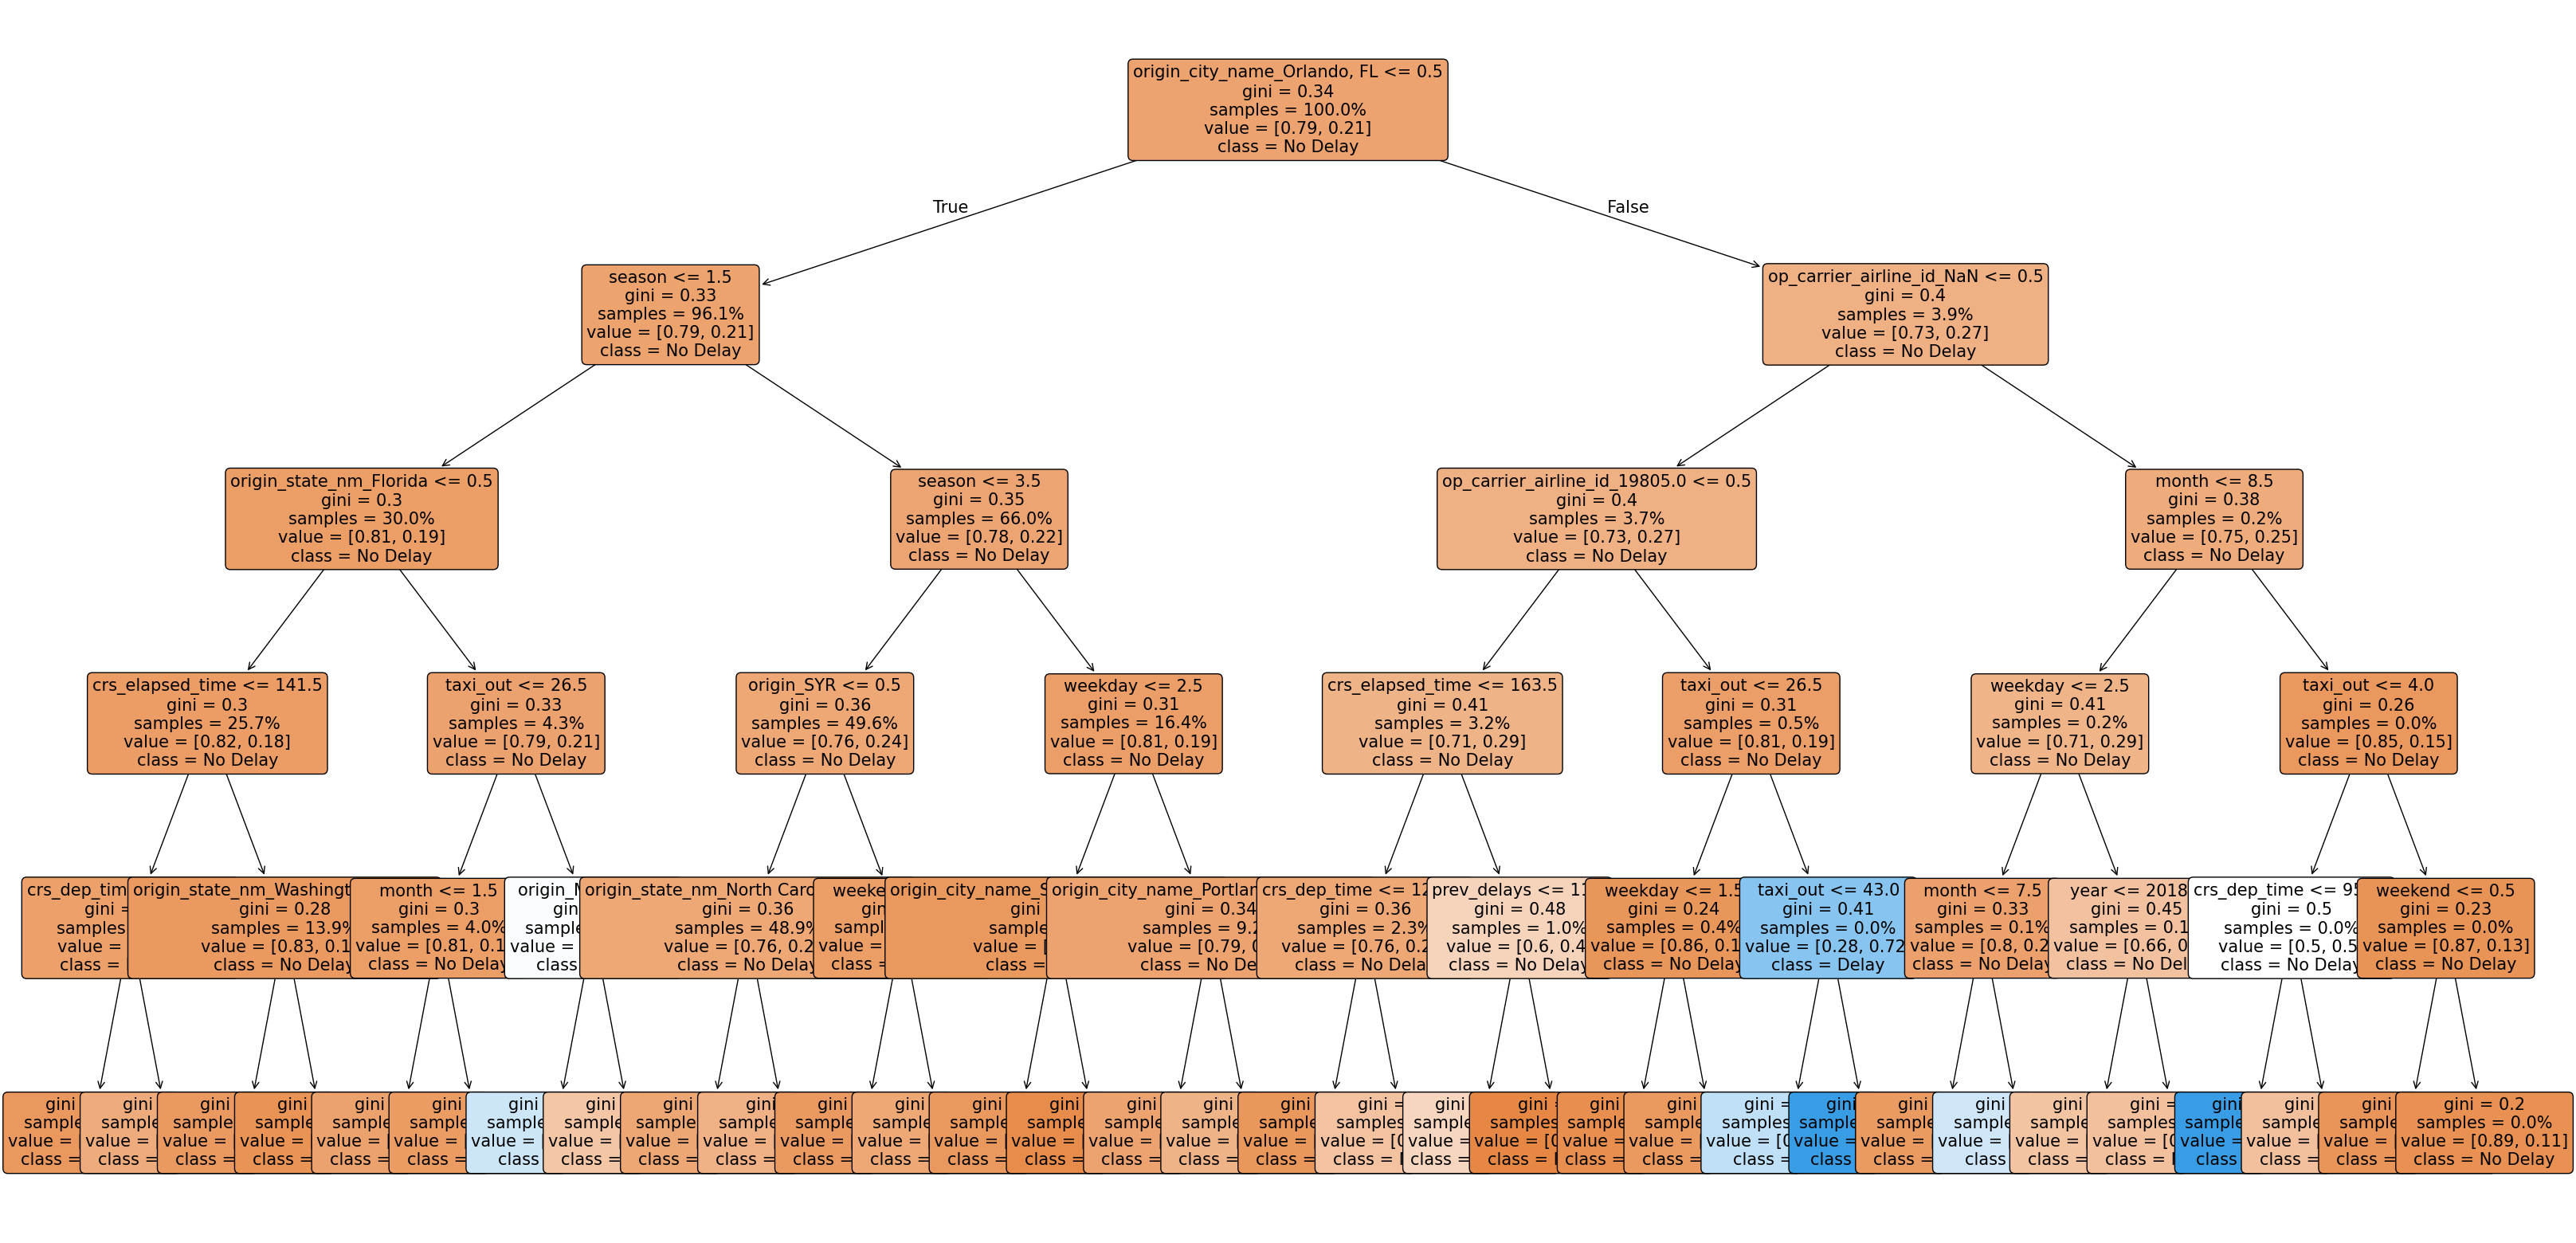

In [80]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[2], 
               ax = ax, 
               fontsize = 15,
               proportion=True,
               filled = True, 
               impurity=True,
               rounded = True,
               precision = 2,
               class_names = ['No Delay', 'Delay'],
               feature_names = X_test.columns);

In [81]:
pd.Series(model5221.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

crs_arr_time                      0.297001
crs_dep_time                      0.210799
taxi_out                          0.194363
season                            0.079867
crs_elapsed_time                  0.044876
origin_state_nm_Florida           0.029482
weekday                           0.020983
origin_city_name_Orlando, FL      0.020055
tail_num_count                    0.019538
op_carrier_airline_id_19805.0     0.008776
op_carrier_airline_id_20304.0     0.008204
month                             0.008091
origin_state_nm_North Carolina    0.007162
origin_ORD                        0.006226
weekend                           0.005393
origin_MIA                        0.004661
origin_city_name_San Jose, CA     0.004104
op_carrier_airline_id_20409.0     0.003706
origin_HOU                        0.003352
prev_delays                       0.003215
dtype: float64

Here we can see that previous delays might gain importance, but not much.